In [1]:
import os
import azureml.core
import pandas as pd
import numpy as np
import logging
import warnings

from pandas.tseries.frequencies import to_offset

# Squash warning messages for cleaner output in the notebook

warnings.showwarning = lambda *args, **kwargs: None

np.set_printoptions(precision=4, suppress=True, linewidth=120)

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.automl.core.featurization import FeaturizationConfig
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from azureml.train.estimator import Estimator

from pandas.io.json import json_normalize

import datetime
from dateutil.tz import tzutc

#!pip install jupyterlab_code_formatter
#https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales/auto-ml-forecasting-orange-juice-sales.ipynb

In [2]:
print('You are currently using version', azureml.core.VERSION, 'of the Azure ML SDK')

You are currently using version 1.20.0 of the Azure ML SDK


In [3]:
%run ./helper.ipynb

In [4]:
# read input files

time_column_name = 'End of Month'
time_column_name1 = 'Snapshot Date Short'
time_column_name2 = 'Snapshot End of Month'
input_data_path = './input-data/'
output_data_path = './output-data/'
talenthist = pd.read_csv(input_data_path + 'TalentHistory.csv',
                         parse_dates=[time_column_name])
revhist = pd.read_csv(input_data_path + 'RevenueHistory.csv',
                      parse_dates=[time_column_name])
opphist = pd.read_csv(input_data_path + 'OppHistory.csv',
                      parse_dates=[time_column_name])
projhist = pd.read_csv(input_data_path + 'ProjectHistory.csv',
                       parse_dates=[time_column_name])
pipetrend = pd.read_csv(input_data_path + 'PipelineTrend.csv',
                        parse_dates=[time_column_name,
                       time_column_name1])
pipehist = pd.read_csv(input_data_path + 'PipelineHistory.csv',
                       parse_dates=[time_column_name,
                       time_column_name1])
display(talenthist.tail())
display(pipehist.tail())
display(revhist.tail())
display(opphist.tail())
display(projhist.tail())
display(pipetrend.tail())


,End of Month,Headcount,Headcount Contingent
56,2021-09-30,489.15,23.00
57,2021-10-31,489.15,23.00
58,2021-11-30,489.15,22.00
59,2021-12-31,489.15,11.00
60,2022-01-31,489.15,11.00


,Snapshot Date Short,Relative Snapshot Month Offset,End of Month,Relative Month Offset,Pipeline,Pipeline 3 Month Rolling Avg,Pipeline 3M Forward Avg,Pipeline 6M Forward Avg,Pipeline 6M Rolling Avg
1806,2021-02-10,0,2021-09-30,7,3723090.29,4589835.98,3111507.82,2172873.70,7065487.53
1807,2021-02-10,0,2021-10-31,8,3057052.70,3826123.60,2576495.31,1664544.07,5450446.21
1808,2021-02-10,0,2021-11-30,9,2554380.49,3111507.82,1868500.77,1222863.32,4494720.65
1809,2021-02-10,0,2021-12-31,10,2118052.74,2576495.31,1234239.58,862036.27,3583165.64
1810,2021-02-10,0,2022-01-31,11,933069.09,1868500.77,752592.83,573930.52,2847312.19


,End of Month,Revenue
46,2020-11-30,14031331.49
47,2020-12-31,14248280.16
48,2021-01-31,13560107.69
49,2021-02-28,1308770.65
50,2021-03-31,1055739.24


,End of Month,Current Opp. Period Value
27,2020-10-31,49435025.38
28,2020-11-30,35118793.64
29,2020-12-31,27136284.50
30,2021-01-31,25882792.80
31,2021-02-28,7253328.60


,End of Month,Conversions
45,2020-10-31,14536849.11
46,2020-11-30,9928454.95
47,2020-12-31,17927536.29
48,2021-01-31,14446751.50
49,2021-02-28,4075810.49


,Snapshot Date Short,End of Month,Pipeline Trend,Pipeline Trend Avg
26,2020-09-27,2020-09-30,32049434.26,10683144.75
27,2020-10-25,2020-10-31,35050408.78,11683469.59
28,2020-11-29,2020-11-30,35824284.22,11941428.07
29,2020-12-27,2020-12-31,38679414.70,12893138.23
30,2021-02-10,2021-02-28,41025314.47,13675104.82


 SP500: 


'SP500'

 DF Info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 2 columns):
End_of_Month    62 non-null datetime64[ns]
sp500           62 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.5 KB


None

 SP500 Describe: 


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,62,62,2017-11-30,1,2016-01-31,2021-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp500,62.000000,NaN,NaT,NaN,NaT,NaT,2728.992742,463.087268,1932.230000,2391.100000,2712.785000,2971.110000,3911.230000


 SP500 Head: 


,End_of_Month,sp500
0,2016-01-31,1940.240000
1,2016-02-29,1932.230000
2,2016-03-31,2059.740000
3,2016-04-30,2065.300000
4,2016-05-31,2096.960000


 SP500 Tail: 


,End_of_Month,sp500
57,2020-10-31,3269.960000
58,2020-11-30,3621.630000
59,2020-12-31,3756.070000
60,2021-01-31,3714.240000
61,2021-02-28,3911.230000


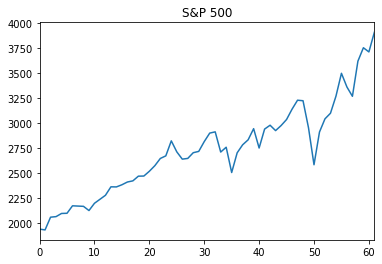

In [5]:
# download SP500 closing prices
# if you get an error after executing the code, try adding below.

pd.set_option('display.float_format', lambda x: '%.6f' % x)

start = datetime.datetime(2016, 1, 1)
end = today

# pd.core.common.is_list_like = pd.api.types.is_list_like
!pip install pandas_datareader
import pandas_datareader.data as web

# SP500 = web.DataReader(['sp500'], 'fred', start, end)
# display(SP500.head())

import pandas_datareader as pdr

SP500 = pdr.get_data_fred('sp500', start, end)
SP500 = SP500.reset_index(level=SP500.index.names)
SP500['End_of_Month'] = SP500['DATE'] + pd.offsets.MonthEnd(0)
SP500 = SP500.sort_values('DATE').groupby('End_of_Month').last()

# SP500['Monthly_Return'] = (SP500['sp500']/ SP500['sp500'].shift(1)) -1
# SP500['sp500_1M_Previous'] = SP500['sp500'].shift(1)

SP500 = SP500.drop('DATE', axis=1)
SP500 = SP500.reset_index(level=SP500.index.names)

#Drop all Not a number values using drop method.
SP500.dropna(inplace = True)
print(' SP500: ')
display(get_df_name(SP500))
print(' DF Info: ')
display(SP500.info(verbose=True))
print(' SP500 Describe: ')
display(SP500.describe(include='all').transpose().head())
print(' SP500 Head: ')
display(SP500.head())
print(' SP500 Tail: ')
display(SP500.tail())
SP500['sp500'].plot(title='S&P 500')

In [6]:
# create an Experiment. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem.
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'revenue-time-forecast1'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['SKU'] = ws.sku
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data=output, index=[''])
outputDf.T


,
Subscription ID,db61fd47-db56-45e3-844f-1b1f5c47990a
Workspace,mlw-bi-automl-devqa01
SKU,Basic
Resource Group,rg-bi-automl-devqa01
Location,westus
Run History Name,revenue-time-forecast1


In [7]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster

amlcompute_cluster_name = 'cc-bi-ml-devqa01'

compute_target = ComputeTarget(workspace=ws,
                               name=amlcompute_cluster_name)
print ('Found existing cluster, use it.')

Found existing cluster, use it.


In [8]:
# Rename Studio, filter studio and prep data

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# exclude_studio = ['Regional Bay Area', 'Regional ChiCamNY', 'Palo Alto', 'Singapore', 'Unknown', 'North America']

# display(exclude_studio)

talenthist1 = talenthist.copy()
pipehist1 = pipehist.copy()
opphist1 = opphist.copy()
projhist1 = projhist.copy()
revhist1 = revhist.copy()
pipetrend1 = pipetrend.copy()
talenthist1.columns = \
    talenthist1.columns.astype(str).str.replace('Contrib ', '')
pipehist1.columns = pipehist1.columns.astype(str).str.replace('Contrib '
        , '')
pipetrend1.columns = \
    pipetrend1.columns.astype(str).str.replace('Contrib ', '')
opphist1.columns = opphist1.columns.astype(str).str.replace('Managing '
        , '')
projhist1.columns = \
    projhist1.columns.astype(str).str.replace('Managing ', '')
revhist1.columns = revhist1.columns.astype(str).str.replace('Managing '
        , '')


pipetrend1.drop(columns='Snapshot Date Short', axis=1, inplace = True)
# talenthist1 = talenthist.rename(columns={'Contrib Studio Name': 'Studio'})
# pipehist1 = pipehist.rename(columns={'Contrib Studio Name': 'Studio'})

# revhist1 = revhist.rename(columns={'Managing Studio Name': 'Studio'})

#pipetrend1 = \
#    pipetrend1.rename(columns={'Snapshot End of Month': 'End of Month'})

                                       # 'Contrib Studio Name': 'Studio'})
# opphist1 = opphist.rename(columns={'Managing Studio Name': 'Studio'})
# projhist1 = projhist.rename(columns={'Managing Studio Name': 'Studio'})
# revhist1 = revhist1.query('End_of_Month < @current_eom').reset_index(drop=True)

display(pipetrend1)
cols_float1 = opphist1.filter(like='Rate', axis=1).columns
remove_percetage(opphist1, cols_float1)
cols_float2 = pipehist1.filter(like='Yield', axis=1).columns
remove_percetage(pipehist1, cols_float2)

talenthist1 = data_prep(talenthist1)
pipehist1 = data_prep(pipehist1)
revhist1 = data_prep(revhist1)
pipetrend1 = data_prep(pipetrend1)
opphist1 = data_prep(opphist1)
projhist1 = data_prep(projhist1)
display(pipetrend1)
coerce_df_columns_to_numeric(talenthist1)
coerce_df_columns_to_numeric(revhist1)
coerce_df_columns_to_numeric(opphist1)
coerce_df_columns_to_numeric(projhist1)
coerce_df_columns_to_numeric(pipehist1)
coerce_df_columns_to_numeric(pipetrend1)
display(pipetrend1)
show_stats(pipehist1)

# revhist1 = revhist1.query('Fin_Entity_ID not in ['SGP',0]').copy()

pipehist1['Snapshot_Date_Short'] = pipehist1['Snapshot_Date_Short'] \
    + pd.offsets.MonthEnd(0)  # make sure all End of Month are end of month dates
pipehist1['End_of_Month'] = pipehist1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)  # make sure all End of Month are end of month dates
pipetrend1['End_of_Month'] = pipetrend1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)  # make sure all End of Month are end of month dates
opphist1['End_of_Month'] = opphist1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)
projhist1['End_of_Month'] = projhist1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)
revhist1['End_of_Month'] = revhist1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)
talenthist1['End_of_Month'] = talenthist1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)

# Sort

pipehist1.sort_values(by=['Snapshot_Date_Short', 'End_of_Month'
                      ]).reset_index(drop=True)
revhist1.sort_values(by=['End_of_Month']).reset_index(drop=True)
talenthist1.sort_values(by=['End_of_Month']).reset_index(drop=True)
pipetrend1.sort_values(by=['End_of_Month']).reset_index(drop=True)
opphist1.sort_values(by=['End_of_Month']).reset_index(drop=True)
projhist1.sort_values(by=['End_of_Month']).reset_index(drop=True)

display(talenthist1.tail())
display(pipehist1.tail())
display(revhist1.tail())
display(opphist1.tail())
display(projhist.tail())
display(pipetrend1.tail())

,End of Month,Pipeline Trend,Pipeline Trend Avg
0,2018-07-31,46427733.68,15475911.23
1,2018-08-31,68924286.95,22974762.32
2,2018-09-30,66374878.74,22124959.58
3,2018-10-31,38846261.03,12948753.68
4,2018-11-30,40477590.79,13492530.26
5,2018-12-31,46724942.71,15574980.90
6,2019-01-31,49480253.87,16493417.96
7,2019-02-28,51666804.39,17222268.13
8,2019-03-31,43195416.63,14398472.21
9,2019-04-30,41047776.31,13682592.10


,End_of_Month,Pipeline_Trend,Pipeline_Trend_Avg
0,2018-07-31,46427733.68,15475911.23
1,2018-08-31,68924286.95,22974762.32
2,2018-09-30,66374878.74,22124959.58
3,2018-10-31,38846261.03,12948753.68
4,2018-11-30,40477590.79,13492530.26
5,2018-12-31,46724942.71,15574980.90
6,2019-01-31,49480253.87,16493417.96
7,2019-02-28,51666804.39,17222268.13
8,2019-03-31,43195416.63,14398472.21
9,2019-04-30,41047776.31,13682592.10


,End_of_Month,Pipeline_Trend,Pipeline_Trend_Avg
0,2018-07-31,46427733,15475911
1,2018-08-31,68924286,22974762
2,2018-09-30,66374878,22124959
3,2018-10-31,38846261,12948753
4,2018-11-30,40477590,13492530
5,2018-12-31,46724942,15574980
6,2019-01-31,49480253,16493417
7,2019-02-28,51666804,17222268
8,2019-03-31,43195416,14398472
9,2019-04-30,41047776,13682592


 DF Name: 


'pipehist1'

 DF Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1811 entries, 0 to 1810
Data columns (total 9 columns):
Snapshot_Date_Short               1811 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    1811 non-null int64
End_of_Month                      1811 non-null datetime64[ns]
Relative_Month_Offset             1811 non-null int64
Pipeline                          1811 non-null int64
Pipeline_3_Month_Rolling_Avg      1811 non-null int64
Pipeline_3M_Forward_Avg           1811 non-null int64
Pipeline_6M_Forward_Avg           1811 non-null int64
Pipeline_6M_Rolling_Avg           1811 non-null int64
dtypes: datetime64[ns](2), int64(7)
memory usage: 127.5 KB


None

 DF Describe: 


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,1811,32,2020-04-30,61,2018-07-31,2021-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,1811.00,NaN,NaT,NaN,NaT,NaT,-14.72,9.10,-31.00,-22.00,-14.00,-7.00,0.00
End_of_Month,1811,61,2017-05-31,32,2017-01-31,2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,1811.00,NaN,NaT,NaN,NaT,NaT,-20.74,17.03,-49.00,-35.00,-21.00,-7.00,11.00
Pipeline,1811.00,NaN,NaT,NaN,NaT,NaT,10081395.82,6377461.00,0.00,1737623.50,13257052.00,14975159.00,29841979.00


 DF Head: 


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg
0,2018-07-31,-31,2017-01-31,-49,12796053,78221403,13171353,13162163,78221403
1,2018-07-31,-31,2017-02-28,-48,12526930,56323245,13055820,12998215,56323245
2,2018-07-31,-31,2017-03-31,-47,14191077,13171353,13436648,13184530,45790203
3,2018-07-31,-31,2017-04-30,-46,12449454,13055820,13152972,13028858,39122053
4,2018-07-31,-31,2017-05-31,-45,13669412,13436648,12940611,13237305,34879946


 DF Tail: 


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg
1806,2021-02-10,0,2021-09-30,7,3723090,4589835,3111507,2172873,7065487
1807,2021-02-10,0,2021-10-31,8,3057052,3826123,2576495,1664544,5450446
1808,2021-02-10,0,2021-11-30,9,2554380,3111507,1868500,1222863,4494720
1809,2021-02-10,0,2021-12-31,10,2118052,2576495,1234239,862036,3583165
1810,2021-02-10,0,2022-01-31,11,933069,1868500,752592,573930,2847312


 EOM Sum:


,End_of_Month,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg
0,2017-01-31,-496,-1568,409473666,2503084896,421483296,421189216,2503084896
1,2017-02-28,-496,-1536,400861730,1802343840,417786240,415942910,1802343840
2,2017-03-31,-496,-1504,454114524,421483296,429972736,421904960,1465286496
3,2017-04-30,-496,-1472,398382438,417786240,420895134,416923486,1251905696
4,2017-05-31,-496,-1440,437421274,429972736,414099582,423593790,1116158302


 EOM Count: 


,End_of_Month,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg
0,2017-01-31,32,32,32,32,32,32,32,32
1,2017-02-28,32,32,32,32,32,32,32,32
2,2017-03-31,32,32,32,32,32,32,32,32
3,2017-04-30,32,32,32,32,32,32,32,32
4,2017-05-31,32,32,32,32,32,32,32,32


 SDS Sum:


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg
0,2018-07-31,-1891,-1159,328902589,450715566,316220798,296426877,550637472
1,2018-08-31,-1830,-1159,341090423,462903142,328408884,308615354,562824653
2,2018-09-30,-1102,-1159,376224683,498080068,363535420,343827525,598164376
3,2018-10-31,-1176,-1197,354818358,476664190,342119542,322349589,576686440
4,2018-11-30,-1134,-1197,385189654,507036794,372492146,352735792,607072643


 SDS Count: 


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg
0,2018-07-31,61,61,61,61,61,61,61,61
1,2018-08-31,61,61,61,61,61,61,61,61
2,2018-09-30,38,38,38,38,38,38,38,38
3,2018-10-31,42,42,42,42,42,42,42,42
4,2018-11-30,42,42,42,42,42,42,42,42


,End_of_Month,Headcount,Headcount_Contingent
56,2021-09-30,489,23
57,2021-10-31,489,23
58,2021-11-30,489,22
59,2021-12-31,489,11
60,2022-01-31,489,11


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg
1806,2021-02-28,0,2021-09-30,7,3723090,4589835,3111507,2172873,7065487
1807,2021-02-28,0,2021-10-31,8,3057052,3826123,2576495,1664544,5450446
1808,2021-02-28,0,2021-11-30,9,2554380,3111507,1868500,1222863,4494720
1809,2021-02-28,0,2021-12-31,10,2118052,2576495,1234239,862036,3583165
1810,2021-02-28,0,2022-01-31,11,933069,1868500,752592,573930,2847312


,End_of_Month,Revenue
46,2020-11-30,14031331
47,2020-12-31,14248280
48,2021-01-31,13560107
49,2021-02-28,1308770
50,2021-03-31,1055739


,End_of_Month,Current_Opp._Period_Value
27,2020-10-31,49435025
28,2020-11-30,35118793
29,2020-12-31,27136284
30,2021-01-31,25882792
31,2021-02-28,7253328


,End of Month,Conversions
45,2020-10-31,14536849.11
46,2020-11-30,9928454.95
47,2020-12-31,17927536.29
48,2021-01-31,14446751.50
49,2021-02-28,4075810.49


,End_of_Month,Pipeline_Trend,Pipeline_Trend_Avg
26,2020-09-30,32049434,10683144
27,2020-10-31,35050408,11683469
28,2020-11-30,35824284,11941428
29,2020-12-31,38679414,12893138
30,2021-02-28,41025314,13675104


In [9]:
pipetrend1

,End_of_Month,Pipeline_Trend,Pipeline_Trend_Avg
0,2018-07-31,46427733,15475911
1,2018-08-31,68924286,22974762
2,2018-09-30,66374878,22124959
3,2018-10-31,38846261,12948753
4,2018-11-30,40477590,13492530
5,2018-12-31,46724942,15574980
6,2019-01-31,49480253,16493417
7,2019-02-28,51666804,17222268
8,2019-03-31,43195416,14398472
9,2019-04-30,41047776,13682592


In [10]:
revhist1

,End_of_Month,Revenue
0,2017-01-31,12796053
1,2017-02-28,12526930
2,2017-03-31,14191077
3,2017-04-30,12449454
4,2017-05-31,13669412
5,2017-06-30,13340051
6,2017-07-31,11812369
7,2017-08-31,13644814
8,2017-09-30,13257051
9,2017-10-31,13700132


In [11]:
display(pipehist1.query('Relative_Snapshot_Month_Offset == 0'))

,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg
1750,2021-02-28,0,2017-01-31,-49,12796052,78221403,13171353,13162163,78221403
1751,2021-02-28,0,2017-02-28,-48,12526929,56323245,13055820,12998216,56323245
1752,2021-02-28,0,2017-03-31,-47,14191079,13171353,13436648,13184530,45790203
1753,2021-02-28,0,2017-04-30,-46,12449451,13055820,13152973,13028859,39122053
1754,2021-02-28,0,2017-05-31,-45,13669415,13436648,12940612,13237306,34879947
...,...,...,...,...,...,...,...,...,...
1806,2021-02-28,0,2021-09-30,7,3723090,4589835,3111507,2172873,7065487
1807,2021-02-28,0,2021-10-31,8,3057052,3826123,2576495,1664544,5450446
1808,2021-02-28,0,2021-11-30,9,2554380,3111507,1868500,1222863,4494720
1809,2021-02-28,0,2021-12-31,10,2118052,2576495,1234239,862036,3583165


In [12]:
print(' revhist1: ')

# revhist1.to_csv('revhist1.csv', index=False)
# show_stats(revhist1)
# display(revhist1.query('Fin_Entity_ID==@entity_debug').reset_index(drop=True))
# pivot

revhist_pivot = revhist1.pivot_table(index='End_of_Month',
        values='Revenue', margins=False)  # columns = ['Fin_Entity_ID'],
                                          # aggfunc=['sum','count'],

# revhist_pivot = revhist_pivot.rename(columns={'sum':'Revenue'})

revhist_pivot = \
    revhist_pivot.reset_index(level=revhist_pivot.index.names)

# revhist_pivot['End_of_Month'] = pd.to_datetime(revhist_pivot['End_of_Month'])#.dt.date
# revhist_pivot.index.name = 'Date'

revhist_pivot.fillna(0, inplace=True)
revhist_pivot.tail(10)


 revhist1: 


,End_of_Month,Revenue
41,2020-06-30,13333553
42,2020-07-31,14995473
43,2020-08-31,12986818
44,2020-09-30,11695095
45,2020-10-31,15433514
46,2020-11-30,14031331
47,2020-12-31,14248280
48,2021-01-31,13560107
49,2021-02-28,1308770
50,2021-03-31,1055739


In [13]:
# Cross join to get all unquie values of End_of_Month and Studio

d = pd.date_range(start_date, end_date, freq='m')
eom = pd.DataFrame(d, columns=['End_of_Month'])

# eom = pipehist_pivot1[['End_of_Month']].drop_duplicates(subset='End_of_Month',keep='last').sort_values(by=['End_of_Month']).reset_index(drop=True)
# studio = pd.DataFrame(talenthist1['Fin_Entity_ID'].unique()), columns=['Fin_Entity_ID'])
# eom['key'] = 0
# studio['key'] = 0
# eom_studio = pd.merge(eom, studio, on=['key'])
# eom_studio = eom_studio.replace(np.nan, 'Unknown', regex=True)
# eom_studio.drop(columns=['key'], axis=1, inplace = True)

print(' EOM: ')

display(eom.info(verbose=True))
eom

 EOM: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 1 columns):
End_of_Month    61 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 616.0 bytes


None

,End_of_Month
0,2017-01-31
1,2017-02-28
2,2017-03-31
3,2017-04-30
4,2017-05-31
...,...
56,2021-09-30
57,2021-10-31
58,2021-11-30
59,2021-12-31


In [14]:
# Merge eom_studio with Revenue, Talent, Opportunity, Project

from functools import reduce
nan_value = 0
merge_dfs = [
    eom,
    revhist1,
    talenthist1,
    opphist1,
    projhist1,
    pipetrend1,
    ]

merge_df = reduce(lambda left, right: pd.merge(left, right, how='left',
                  on=['End_of_Month']), merge_dfs).fillna(nan_value)
coerce_df_columns_to_numeric(merge_df)
merge_df = merge_df.replace(np.nan, 0, regex=True)

# merge_df = merge_df.query('Fin_Entity_ID!='SGP'') # Exclude Singapore rows

merge_df['Relative_Month_Offset'] = round((merge_df['End_of_Month']
        - current_eom) / np.timedelta64(1, 'M'), 0).astype(int)
merge_df['Billable_Headcount'] = merge_df['Headcount'] \
    + merge_df['Headcount_Contingent']
merge_df.sort_values(by=['End_of_Month']).reset_index(drop=True)

# merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)

print(' merge_df: ')

# merge_df.to_csv(output_data_path + 'merge_df.csv', index=False)
# show_stats(merge_df)

merge_df  # .query('Fin_Entity_ID==@entity_debug')')

 merge_df: 


,End_of_Month,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount
0,2017-01-31,12796053,486,26,0,13505689,0,0,-49,512
1,2017-02-28,12526930,485,25,0,8659143,0,0,-48,510
2,2017-03-31,14191077,487,25,0,12745281,0,0,-47,512
3,2017-04-30,12449454,483,25,0,10701239,0,0,-46,508
4,2017-05-31,13669412,490,22,0,6457961,0,0,-45,512
...,...,...,...,...,...,...,...,...,...,...
56,2021-09-30,0,489,23,0,0,0,0,7,512
57,2021-10-31,0,489,23,0,0,0,0,8,512
58,2021-11-30,0,489,22,0,0,0,0,9,511
59,2021-12-31,0,489,11,0,0,0,0,10,500


In [15]:
# Merge with SP500

eom1 = eom  # pd.DataFrame(d, columns=['End_of_Month'])
sp500_df = pd.merge(eom1, SP500, how='left', on=['End_of_Month'])

# sp500_df = sp500_df.ffill(axis = 0)

sp500_df = sp500_df.sort_values(by=['End_of_Month'
                                ]).reset_index(drop=True)
display(sp500_df)
merge_df1 = pd.merge(merge_df, sp500_df, how='left', on=['End_of_Month'
                     ])
coerce_df_columns_to_numeric(merge_df1)
merge_df1.drop(columns=['Headcount', 'Headcount_Contingent'], axis=1,
               inplace=True)  # ,'Total_Headcount','Monthly_Return','sp500_1M_Previous'
merge_df1 = merge_df1.sort_values(by=['End_of_Month'
                                  ]).reset_index(drop=True)
merge_df1.to_csv(output_data_path + 'merge_df1.csv', index=False)
show_stats(merge_df1)

,End_of_Month,sp500
0,2017-01-31,2278.87
1,2017-02-28,2363.64
2,2017-03-31,2362.72
3,2017-04-30,2384.20
4,2017-05-31,2411.80
...,...,...
56,2021-09-30,nan
57,2021-10-31,nan
58,2021-11-30,nan
59,2021-12-31,nan


 DF Name: 


'merge_df1'

 DF Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 9 columns):
End_of_Month                 61 non-null datetime64[ns]
Revenue                      61 non-null int64
Current_Opp._Period_Value    61 non-null int64
Conversions                  61 non-null int64
Pipeline_Trend               61 non-null int64
Pipeline_Trend_Avg           61 non-null int64
Relative_Month_Offset        61 non-null int64
Billable_Headcount           61 non-null int64
sp500                        50 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 4.4 KB


None

 DF Describe: 


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,61,61,2017-11-30,1,2017-01-31,2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,61.00,NaN,NaT,NaN,NaT,NaT,11583609.66,5843224.47,0.00,11814066.00,13700132.00,15067398.00,18078330.00
Current_Opp._Period_Value,61.00,NaN,NaT,NaN,NaT,NaT,20766272.75,22996799.53,0.00,0.00,21167634.00,39029221.00,108042955.00
Conversions,61.00,NaN,NaT,NaN,NaT,NaT,9981808.61,6382228.46,0.00,6457961.00,10343606.00,13818975.00,24866866.00
Pipeline_Trend,61.00,NaN,NaT,NaN,NaT,NaT,21966708.79,22502563.65,0.00,0.00,32049434.00,42624711.00,68924286.00


 DF Head: 


,End_of_Month,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount,sp500
0,2017-01-31,12796053,0,13505689,0,0,-49,512,2278.87
1,2017-02-28,12526930,0,8659143,0,0,-48,510,2363.64
2,2017-03-31,14191077,0,12745281,0,0,-47,512,2362.72
3,2017-04-30,12449454,0,10701239,0,0,-46,508,2384.20
4,2017-05-31,13669412,0,6457961,0,0,-45,512,2411.80


 DF Tail: 


,End_of_Month,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount,sp500
56,2021-09-30,0,0,0,0,0,7,512,nan
57,2021-10-31,0,0,0,0,0,8,512,nan
58,2021-11-30,0,0,0,0,0,9,511,nan
59,2021-12-31,0,0,0,0,0,10,500,nan
60,2022-01-31,0,0,0,0,0,11,500,nan


 EOM Sum:


,End_of_Month,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount,sp500
0,2017-01-31,12796053,0,13505689,0,0,-49,512,2278.87
1,2017-02-28,12526930,0,8659143,0,0,-48,510,2363.64
2,2017-03-31,14191077,0,12745281,0,0,-47,512,2362.72
3,2017-04-30,12449454,0,10701239,0,0,-46,508,2384.20
4,2017-05-31,13669412,0,6457961,0,0,-45,512,2411.80


 EOM Count: 


,End_of_Month,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount,sp500
0,2017-01-31,1,1,1,1,1,1,1,1
1,2017-02-28,1,1,1,1,1,1,1,1
2,2017-03-31,1,1,1,1,1,1,1,1
3,2017-04-30,1,1,1,1,1,1,1,1
4,2017-05-31,1,1,1,1,1,1,1,1


In [146]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# Calculate pipeline month offset for corresponding snapshot dates

#Set Parameters---------------------------------------------------------------------------------------------------------------------
sort_cols = ['Snapshot_Date_Short', 'End_of_Month']
n_test_periods = 4
rolling_pipeline_period = 4
relative_offset_periods = 11
pipehist_long = pipehist1.copy()

pipehist_long['Relative_Offset'] = pipehist_long['Relative_Month_Offset'
        ] - pipehist_long['Relative_Snapshot_Month_Offset']
pipehist_long = \
    pipehist_long.query('Relative_Offset >= -@relative_offset_periods and \
                        Relative_Offset < @rolling_pipeline_period and \
                        Snapshot_Date_Short < @end_date'
                        )
cols = 'Relative_Offset'
pipehist_long[cols] = pipehist_long[cols].apply(pd.to_numeric,
        errors='coerce')

# pipehist2 = pipehist2.query('Relative_Offset>=-11 and Relative_Offset<=0')
# pipehist_long['Relative_Offset'] = pipehist_long['Relative_Offset'].astype(str).str.zfill(2) + 'M Pipeline'
# pipehist_long['Relative_Offset'] = pipehist_long['Relative_Offset'].str.replace('0','+')
# pipehist_long['Relative_Offset'] = pipehist_long['Relative_Offset'].str.replace('++M Pipeline','+0M Pipeline')
# pipehist_long['Relative_Offset'] = 'Relative' + pipehist_long['Relative_Offset'].str.replace('0-','-0')

pipehist_long.sort_values(by=sort_cols).reset_index(drop=True)  # ,'Fin_Entity_ID'

print (' pipehist_long: ')

pipehist_long.to_csv(output_data_path + 'pipehist_long.csv',
                     index=False)
display(pipehist_long)  # .query('Fin_Entity_ID==@entity_debug'))
pipehist_long.info()

 pipehist_long: 


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset
7,2018-07-31,-31,2017-08-31,-42,13644814,12932411,13533999,13422283,13184530,-11
8,2018-07-31,-31,2017-09-30,-41,13257051,12904745,13462141,13306936,13028858,-10
9,2018-07-31,-31,2017-10-31,-40,13700132,13533999,12981146,13608660,13237305,-9
10,2018-07-31,-31,2017-11-30,-39,13429239,13462141,13310566,13758270,13197276,-8
11,2018-07-31,-31,2017-12-31,-38,11814066,12981146,13151731,14219427,12942945,-7
...,...,...,...,...,...,...,...,...,...,...
1798,2021-02-28,0,2021-01-31,-1,13560108,13946575,14949788,12245463,13659193,-1
1799,2021-02-28,0,2021-02-28,0,13606905,13805098,14678852,10876810,13762540,0
1800,2021-02-28,0,2021-03-31,1,17682351,14949788,12906128,9392031,14760416,1
1801,2021-02-28,0,2021-04-30,2,12747300,14678852,9541139,7065487,14312713,2


<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 7 to 1802
Data columns (total 10 columns):
Snapshot_Date_Short               480 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    480 non-null int64
End_of_Month                      480 non-null datetime64[ns]
Relative_Month_Offset             480 non-null int64
Pipeline                          480 non-null int64
Pipeline_3_Month_Rolling_Avg      480 non-null int64
Pipeline_3M_Forward_Avg           480 non-null int64
Pipeline_6M_Forward_Avg           480 non-null int64
Pipeline_6M_Rolling_Avg           480 non-null int64
Relative_Offset                   480 non-null int64
dtypes: datetime64[ns](2), int64(8)
memory usage: 41.2 KB


In [147]:
# Convert pipe history from long to wide to match month end grain

pipehist_wide = pipehist_long.pivot_table(index='Snapshot_Date_Short', columns='Relative_Offset',
        values=['Pipeline', 'Pipeline_3_Month_Rolling_Avg'],
        aggfunc={'Pipeline':np.sum , 'Pipeline_3_Month_Rolling_Avg':np.mean}, margins=False)  # ,'Fin_Entity_ID'
pipehist_wide = \
    pipehist_wide.reset_index(level=pipehist_wide.index.names).reset_index(drop=True)
cols = list(pipehist_wide.select_dtypes(include='float64').columns)
coerce_df_columns_to_numeric(pipehist_wide)
pipehist_wide['Snapshot_Date_Short'] = \
    pd.to_datetime(pipehist_wide['Snapshot_Date_Short'])

# pipehist_wide.rename(columns={0:'Pipeline_3_Month_Rolling_Avg'}, inplace=True)

pipehist_wide = pipehist_wide.sort_values(by='Snapshot_Date_Short').reset_index(drop=True)

print(' pipehist_wide: ')

display(pipehist_wide.info())

# pipehist_wide.query('Fin_Entity_ID==@entity_debug')

pipehist_wide

 pipehist_wide: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 31 columns):
(Snapshot_Date_Short, )                32 non-null datetime64[ns]
(Pipeline, -11)                        32 non-null int64
(Pipeline, -10)                        32 non-null int64
(Pipeline, -9)                         32 non-null int64
(Pipeline, -8)                         32 non-null int64
(Pipeline, -7)                         32 non-null int64
(Pipeline, -6)                         32 non-null int64
(Pipeline, -5)                         32 non-null int64
(Pipeline, -4)                         32 non-null int64
(Pipeline, -3)                         32 non-null int64
(Pipeline, -2)                         32 non-null int64
(Pipeline, -1)                         32 non-null int64
(Pipeline, 0)                          32 non-null int64
(Pipeline, 1)                          32 non-null int64
(Pipeline, 2)                          32 non-null int64
(Pipeline, 3)   

None

Snapshot_Date_Short  Pipeline                                                                                                                                             Pipeline_3_Month_Rolling_Avg                                                                                                                                            
Relative_Offset                           -11       -10        -9        -8        -7        -6        -5        -4        -3        -2        -1         0         1         2         3                          -11       -10        -9        -8        -7        -6        -5        -4        -3        -2        -1         0         1         2         3
0               2018-07-31           13644814  13257051  13700132  13429239  11814066  14688394  12952733  15067398  14597789  16196182  14816107  13046088  19060368  16240819  16378066  12932411                     12904745  13533999  13462141  12981146  13310566  13151731  14236175  14205974  15287123  15203360  14686126  15640855  16115759  17226418
1               2018-08-31           13257051  13700132  13429239  11814066  14688394  12952733  15067398  14597789  16196182  14816107  14385070  14014614  16891818  21721977  15793985  12904745                     13533999  13462141  12981146  13310566  13151731  14236175  14205974  15287123  15203360  15132453  14405264  15097168  17542803  18135927
2               2018-09-30           13700136  13429238  11814068  14688394  12952734  15067398  14597789  16196183  14816107  14385074  15827441  13525107  29841979  26499633  15495235  13534001                     13462142  12981147  13310566  13151732  14236175  14205974  15287123  15203359  15132455  15009541  14579208  19731509  23288906  23945616
3               2018-10-31           13429238  11814068  14688394  12952734  15067398  14597789  16196183  14816107  14385074  15827440  14759301  16301930  15885521  13170992  10173074  13462142                     12981147  13310566  13151732  14236175  14205974  15287123  15203359  15132455  15009540  14990605  15629557  15648917  15119481  13076529
4               2018-11-30           11814068  14688394  12952734  15067398  14597789  16196183  14816107  14385074  15827440  14759301  17179430  13677010  14075893  16270536  12916691  12981147                     13310566  13151732  14236175  14205974  15287123  15203359  15132455  15009540  14990605  15922057  15205247  14977444  14674479  14421040
5               2018-12-31           14688394  12952734  15067398  14597789  16196183  14816107  14384071  15827441  14759381  17179425  14995706  11497210  16856017  16873208  14972749  13310566                     13151732  14236175  14205974  15287123  15203359  15132120  15009206  14990298  15922082  15644837  14557447  14449644  15075478  16233991
6               2019-01-31           12952734  15067398  14597789  16196183  14816107  14384071  15827441  14759381  17179425  14995706  13193823  13445091  15591803  17814733  15682275  13151732                     14236175  14205974  15287123  15203359  15132120  15009206  14990298  15922082  15644837  15122985  13878207  14076906  15617209  16362937
7               2019-02-28           15067398  14597789  16196183  14816107  14384071  15827441  14759381  17179425  14995706  13193823  15784854  13596671  20281051  19938663  13563585  14236175                     14205973  15287123  15203360  15132120  15009206  14990298  15922082  15644837  15122985  14658128  14191783  16554192  17938795  17927767
8               2019-03-31           14597789  16196183  14816107  14384071  15827441  14759381  17179425  14995706  13193823  15644438  14968946  16087194  17373416  15827223  11592341  14205973                     15287123  15203360  15132120  15009206  14990298  15922082  15644837  15122985  14611322  14602402  15566859  16143185  16429278  14930993
9               2019-04-30           16196183  14816107  14384071  15827441  14759381  17179425  14995706  1319

In [148]:
'''
# Merge merge_df with Pipeline Long History
# pipe_offset = ['Relative-00','Relative-01','Relative-02','Relative-03',
#               'Relative-04','Relative-05','Relative-06'
#               ,'Relative-07', 'Relative-08','Relative-09','Relative-10','Relative-11'
#              ]
# 1merge_final = pd.merge(merge_df1, pipehist_long.query('Relative_Offset == 0'), how='left', on=['End_of_Month','Relative_Month_Offset','Fin_Entity_ID'])
# 1merge_final.drop(columns=['Snapshot_Date_Short','Relative_Snapshot_Month_Offset'], axis=1, inplace = True)
# New Code
'''

pipehist_long1 = pipehist_long.copy() 
merge_final = pd.merge(pipehist_long1, merge_df1, how='right',
                       on=['End_of_Month', 'Relative_Month_Offset'])
merge_final = merge_final.query('Relative_Snapshot_Month_Offset <= 0')
# merge_final.drop(columns=['Snapshot_Date_Short','Relative_Snapshot_Month_Offset'], axis=1, inplace = True)
# New Code end

merge_final['End_of_Month'] = pd.to_datetime(merge_final['End_of_Month'
        ])
merge_final['Relative_Month_Offset'] = round((merge_final['End_of_Month'
        ] - current_eom) / np.timedelta64(1, 'M'), 0)
coerce_df_columns_to_numeric(merge_final)

merge_final['Relative_Offset'] = merge_final['Relative_Offset'
        ].apply(pd.to_numeric, errors='coerce').replace(np.nan, 0,
        regex=True).astype(int)
cond = ~merge_final['Snapshot_Date_Short'].isna()
merge_final['Snapshot_Date_Short'] = np.where(cond,
        merge_final['Snapshot_Date_Short'], merge_final['End_of_Month'])
merge_final['Relative_Snapshot_Month_Offset'] = \
    round((merge_final['Snapshot_Date_Short'] - current_eom)
          / np.timedelta64(1, 'M'), 0).astype(int)

# Filter for only next 11 months rows w.r.t. to snapshot date
# revpipe_final1 = revpipe_final.query('Relative_Offset in @pipe_offset').reset_index(drop=True)
# merge_final = merge_final.replace(np.nan, 0, regex=True)
coerce_df_columns_to_numeric(merge_final)
merge_final = merge_final.sort_values(by=sort_cols).reset_index(drop=True)
display(merge_final.info())
merge_final.rename(columns={
    -12: '-12M Pipeline',
    -11: '-11M Pipeline',
    -10: '-10M Pipeline',
    -9: '-9M Pipeline',
    -8: '-8M Pipeline',
    -7: '-7M Pipeline',
    -6: '-6M Pipeline',
    -5: '-5M Pipeline',
    -4: '-4M Pipeline',
    -3: '-3M Pipeline',
    -2: '-2M Pipeline',
    -1: '-1M Pipeline',
    0: '0M Pipeline',
    1: '1M Pipeline',
    2: '2M Pipeline',
    3: '3M Pipeline',
    4: '4M Pipeline',
    5: '5M Pipeline',
    6: '6M Pipeline',
    7: '7M Pipeline',
    8: '8M Pipeline',
    9: '9M Pipeline',
    10: '10M Pipeline',
    11: '11M Pipeline',
    }, inplace=True)

print(' merge_final: ')

merge_final.to_csv(output_data_path + 'merge_final.csv', index=False)
merge_final.to_parquet(output_data_path + 'merge_final.parquet',
                       index=None)
show_stats(merge_final)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
Snapshot_Date_Short               480 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    480 non-null int64
End_of_Month                      480 non-null datetime64[ns]
Relative_Month_Offset             480 non-null int64
Pipeline                          480 non-null int64
Pipeline_3_Month_Rolling_Avg      480 non-null int64
Pipeline_3M_Forward_Avg           480 non-null int64
Pipeline_6M_Forward_Avg           480 non-null int64
Pipeline_6M_Rolling_Avg           480 non-null int64
Relative_Offset                   480 non-null int64
Revenue                           480 non-null int64
Current_Opp._Period_Value         480 non-null int64
Conversions                       480 non-null int64
Pipeline_Trend                    480 non-null int64
Pipeline_Trend_Avg                480 non-null int64
Billable_Headcount                480 non-null int64
sp500                        

None

 merge_final: 
 DF Name: 


'merge_final'

 DF Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
Snapshot_Date_Short               480 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    480 non-null int64
End_of_Month                      480 non-null datetime64[ns]
Relative_Month_Offset             480 non-null int64
Pipeline                          480 non-null int64
Pipeline_3_Month_Rolling_Avg      480 non-null int64
Pipeline_3M_Forward_Avg           480 non-null int64
Pipeline_6M_Forward_Avg           480 non-null int64
Pipeline_6M_Rolling_Avg           480 non-null int64
Relative_Offset                   480 non-null int64
Revenue                           480 non-null int64
Current_Opp._Period_Value         480 non-null int64
Conversions                       480 non-null int64
Pipeline_Trend                    480 non-null int64
Pipeline_Trend_Avg                480 non-null int64
Billable_Headcount                480 non-null int64
sp500             

None

 DF Describe: 


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,480,32,2020-04-30,15,2018-07-31,2021-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,480.0,NaN,NaT,NaN,NaT,NaT,-15.5,9.2,-31.0,-23.2,-15.5,-7.8,0.0
End_of_Month,480,46,2018-11-30,15,2017-08-31,2021-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,480.0,NaN,NaT,NaN,NaT,NaT,-19.5,10.2,-42.0,-27.2,-19.5,-11.8,3.0
Pipeline,480.0,NaN,NaT,NaN,NaT,NaT,14897713.0,1964715.6,8288733.0,13825969.0,14995473.0,15827441.0,29841979.0


 DF Head: 


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
0,2018-07-31,-31,2017-08-31,-42,13644814,12932411,13533999,13422283,13184530,-11,13644814,0,6762094,0,0,519,2471.7
1,2018-07-31,-31,2017-09-30,-41,13257051,12904745,13462141,13306936,13028858,-10,13257051,0,4530171,0,0,519,2519.4
2,2018-07-31,-31,2017-10-31,-40,13700132,13533999,12981146,13608660,13237305,-9,13700132,0,6782319,0,0,539,2575.3
3,2018-07-31,-31,2017-11-30,-39,13429239,13462141,13310566,13758270,13197276,-8,13429239,0,7408248,0,0,548,2647.6
4,2018-07-31,-31,2017-12-31,-38,11814066,12981146,13151731,14219427,12942945,-7,11814066,0,4170817,0,0,531,2673.6


 DF Tail: 


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
475,2021-02-28,0,2021-01-31,-1,13560108,13946575,14949788,12245463,13659193,-1,13560107,25882792,14446751,0,0,531,3714.2
476,2021-02-28,0,2021-02-28,0,13606905,13805098,14678852,10876810,13762540,0,1308770,7253328,4075810,41025314,13675104,525,3911.2
477,2021-02-28,0,2021-03-31,1,17682351,14949788,12906128,9392031,14760416,1,1055739,0,0,0,0,521,nan
478,2021-02-28,0,2021-04-30,2,12747300,14678852,9541139,7065487,14312713,2,0,0,0,0,0,516,nan
479,2021-02-28,0,2021-05-31,3,8288733,12906128,7074768,5450446,13355613,3,0,0,0,0,0,516,nan


 EOM Sum:


,End_of_Month,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
0,2017-08-31,-31,-42,13644814,12932411,13533999,13422283,13184530,-11,13644814,0,6762094,0,0,519,2471.7
1,2017-09-30,-61,-82,26514102,25809490,26924282,26613872,26057716,-21,26514102,0,9060342,0,0,1038,5038.7
2,2017-10-31,-90,-120,41100400,40601999,38943439,40825981,39711916,-30,41100396,0,20346957,0,0,1617,7725.8
3,2017-11-30,-118,-156,53716954,53848566,53242264,55033080,52789106,-38,53716956,0,29632992,0,0,2192,10590.3
4,2017-12-31,-145,-190,59070336,64905733,65758658,71097135,64714728,-45,59070330,0,20854085,0,0,2655,13368.1


 EOM Count: 


,End_of_Month,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
0,2017-08-31,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2017-09-30,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,2017-10-31,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
3,2017-11-30,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4,2017-12-31,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


 SDS Sum:


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
0,2018-07-31,-465,-525,218889246,214878529,213610763,198079948,210152127,-60,216314222,243904304,156913478,220573158,73524385,8368,40481.2
1,2018-08-31,-450,-510,223326555,218590575,215872435,198648370,212715621,-60,217665115,289925951,163336537,261050748,87016915,8456,40769.7
2,2018-09-30,-435,-495,242836516,237059454,236466336,220548673,222965322,-60,217601885,330161209,169755199,307775690,102591895,8532,40757.2
3,2018-10-31,-420,-480,214065243,216445302,204417087,186256044,214208417,-60,219546190,375052371,187839746,357255943,119085312,8598,40886.0
4,2018-11-30,-405,-465,219224048,218708943,214438575,198937671,216622905,-60,221092099,396220005,194250473,408922747,136307580,8659,41022.9


 SDS Count: 


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
0,2018-07-31,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
1,2018-08-31,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
2,2018-09-30,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
3,2018-10-31,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
4,2018-11-30,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15


In [149]:
# To distinguish the individual time-series, we define the time_series_id_column_names - the columns whose values determine the boundaries between time-series:

target_column_name = 'Revenue'
time_column_name = 'Snapshot_Date_Short'
time_series_id_column_names = ['Relative_Offset']
sort_list = [time_column_name] + list(set(time_series_id_column_names))
df = merge_final.copy()

In [150]:
# Data Split
# split the data into a training and a testing set for later forecast evaluation. The test set will contain the final test_size months of observed sales for each time-series.
# The splits should be stratified by series, so we use a group-by statement on the time series identifier columns.
# test_size = .11 #in percentage
# n_test_periods =  int(tseries * test_size)
# n_test_periods = rolling_pipeline_period

In [151]:
tseries = df.groupby(time_column_name).ngroups
display('Data contains {0} individual time_column_name.'.format(tseries))
test_size = round(n_test_periods / tseries, 2)
display('Test Size: ', test_size, 'Test Periods: ', n_test_periods)
display(df[time_column_name].unique())

'Data contains 32 individual time_column_name.'

'Test Size: '

0.12

'Test Periods: '

4

array(['2018-07-31T00:00:00.000000000', '2018-08-31T00:00:00.000000000', '2018-09-30T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-11-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000',
       '2019-01-31T00:00:00.000000000', '2019-02-28T00:00:00.000000000', '2019-03-31T00:00:00.000000000',
       '2019-04-30T00:00:00.000000000', '2019-05-31T00:00:00.000000000', '2019-06-30T00:00:00.000000000',
       '2019-07-31T00:00:00.000000000', '2019-08-31T00:00:00.000000000', '2019-09-30T00:00:00.000000000',
       '2019-10-31T00:00:00.000000000', '2019-11-30T00:00:00.000000000', '2019-12-31T00:00:00.000000000',
       '2020-01-31T00:00:00.000000000', '2020-02-29T00:00:00.000000000', '2020-03-31T00:00:00.000000000',
       '2020-04-30T00:00:00.000000000', '2020-05-31T00:00:00.000000000', '2020-06-30T00:00:00.000000000',
       '2020-07-31T00:00:00.000000000', '2020-08-31T00:00:00.000000000', '2020-09-30T00:00:00.000000000',
       '2020-10-31T00:00:00.000000000', '2020-

In [152]:
# df = merge_final.drop(columns=['End_of_Month','Relative_Month_Offset']).sort_values(by=sort_list)# axis=1, inplace = True)

nseries = df.groupby(time_series_id_column_names).ngroups
display('Data contains {0} individual time-series.'.format(nseries))
display(sort_list)
display(df['Relative_Offset'].unique())
display(df['End_of_Month'].unique())

'Data contains 15 individual time-series.'

['Snapshot_Date_Short', 'Relative_Offset']

array([-11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3])

array(['2017-08-31T00:00:00.000000000', '2017-09-30T00:00:00.000000000', '2017-10-31T00:00:00.000000000',
       '2017-11-30T00:00:00.000000000', '2017-12-31T00:00:00.000000000', '2018-01-31T00:00:00.000000000',
       '2018-02-28T00:00:00.000000000', '2018-03-31T00:00:00.000000000', '2018-04-30T00:00:00.000000000',
       '2018-05-31T00:00:00.000000000', '2018-06-30T00:00:00.000000000', '2018-07-31T00:00:00.000000000',
       '2018-08-31T00:00:00.000000000', '2018-09-30T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-11-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000', '2019-01-31T00:00:00.000000000',
       '2019-02-28T00:00:00.000000000', '2019-03-31T00:00:00.000000000', '2019-04-30T00:00:00.000000000',
       '2019-05-31T00:00:00.000000000', '2019-06-30T00:00:00.000000000', '2019-07-31T00:00:00.000000000',
       '2019-08-31T00:00:00.000000000', '2019-09-30T00:00:00.000000000', '2019-10-31T00:00:00.000000000',
       '2019-11-30T00:00:00.000000000', '2019-

In [153]:
#train, test = split_full_for_forecasting(df=df, time_column_name=time_column_name, grain_column_names=time_series_id_column_names, test_split=test_size)

(train, test) = split_last_n_by_series_id(df, n_test_periods)



#train = df.query('Relative_Snapshot_Month_Offset <= -@n_test_periods')
#test = df.drop(train.index)
# test = merge_final1.query('(End_of_Month >= @current_eom)')#.sort_values(by=time_column_name)#.reset_index(drop=True)
# train = merge_final1.drop(test.index)#.sort_values(by=sort_list)#('(

display(df.shape)
display(train.shape)
display(test.shape)

# df1 = df.copy()
# train = df1.sample(frac=train_size, random_state=0)
# test = df1.drop(train.index)
# train_size = int(df.shape[0] * 0.9)
# train = df[:n_test_periods]
# test = df[n_test_periods:]

train.to_csv(output_data_path + r'./revtime_train.csv', index=None,
             header=True)
test.to_csv(output_data_path + r'./revtime_test.csv', index=None,
            header=True)

# train_file_path = 'train.csv'
# test_file_path = 'eval.csv'

(480, 17)

(420, 17)

(60, 17)

In [154]:
# Summary Stats for Train and Test dataframes

print ('Train************************')
display(train.info(verbose=True))
display(train.describe(include='all').transpose().head())
display(train)

Train************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 419
Data columns (total 17 columns):
Snapshot_Date_Short               420 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    420 non-null int64
End_of_Month                      420 non-null datetime64[ns]
Relative_Month_Offset             420 non-null int64
Pipeline                          420 non-null int64
Pipeline_3_Month_Rolling_Avg      420 non-null int64
Pipeline_3M_Forward_Avg           420 non-null int64
Pipeline_6M_Forward_Avg           420 non-null int64
Pipeline_6M_Rolling_Avg           420 non-null int64
Relative_Offset                   420 non-null int64
Revenue                           420 non-null int64
Current_Opp._Period_Value         420 non-null int64
Conversions                       420 non-null int64
Pipeline_Trend                    420 non-null int64
Pipeline_Trend_Avg                420 non-null int64
Billable_Headcount                420 non-null int64

None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,420,28,2020-04-30,15,2018-07-31,2020-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,420.0,NaN,NaT,NaN,NaT,NaT,-17.5,8.1,-31.0,-24.2,-17.5,-10.8,-4.0
End_of_Month,420,42,2019-02-28,15,2017-08-31,2021-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,420.0,NaN,NaT,NaN,NaT,NaT,-21.5,9.2,-42.0,-28.2,-21.5,-14.8,-1.0
Pipeline,420.0,NaN,NaT,NaN,NaT,NaT,15060720.5,1937823.2,8649836.0,14337139.0,15067398.0,15828272.0,29841979.0


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
0,2018-07-31,-31,2017-08-31,-42,13644814,12932411,13533999,13422283,13184530,-11,13644814,0,6762094,0,0,519,2471.7
15,2018-08-31,-30,2017-09-30,-41,13257051,12904745,13462141,13306936,13028858,-11,13257051,0,4530171,0,0,519,2519.4
30,2018-09-30,-29,2017-10-31,-40,13700136,13534001,12981147,13608661,13237306,-11,13700132,0,6782319,0,0,539,2575.3
45,2018-10-31,-28,2017-11-30,-39,13429238,13462142,13310566,13758270,13197277,-11,13429239,0,7408248,0,0,548,2647.6
60,2018-11-30,-27,2017-12-31,-38,11814068,12981147,13151732,14219427,12942946,-11,11814066,0,4170817,0,0,531,2673.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,2020-06-30,-8,2020-09-30,-5,12061956,13732828,9509466,6154179,12988861,3,11695095,33449833,10437439,32049434,10683144,584,3363.0
374,2020-07-31,-7,2020-10-31,-4,12036730,13564901,8255915,5212469,13381783,3,15433514,49435025,14536849,35050408,11683469,579,3270.0
389,2020-08-31,-6,2020-11-30,-3,9545051,12421403,6576357,4390583,13109913,3,14031331,35118793,9928454,35824284,11941428,576,3621.6
404,2020-09-30,-5,2020-12-31,-2,8649836,12194316,6640645,4659048,12655965,3,14248280,27136284,17927536,38679414,12893138,530,3756.1


In [155]:
print ('Test************************')
display(test.info(verbose=True))
display(test.describe(include='all').transpose().head())
display(test)

Test************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 420 to 479
Data columns (total 17 columns):
Snapshot_Date_Short               60 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    60 non-null int64
End_of_Month                      60 non-null datetime64[ns]
Relative_Month_Offset             60 non-null int64
Pipeline                          60 non-null int64
Pipeline_3_Month_Rolling_Avg      60 non-null int64
Pipeline_3M_Forward_Avg           60 non-null int64
Pipeline_6M_Forward_Avg           60 non-null int64
Pipeline_6M_Rolling_Avg           60 non-null int64
Relative_Offset                   60 non-null int64
Revenue                           60 non-null int64
Current_Opp._Period_Value         60 non-null int64
Conversions                       60 non-null int64
Pipeline_Trend                    60 non-null int64
Pipeline_Trend_Avg                60 non-null int64
Billable_Headcount                60 non-null int64
sp500          

None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,60,4,2021-02-28,15,2020-11-30,2021-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,60.0,NaN,NaT,NaN,NaT,NaT,-1.5,1.1,-3.0,-2.2,-1.5,-0.8,0.0
End_of_Month,60,18,2021-01-31,4,2019-12-31,2021-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,60.0,NaN,NaT,NaN,NaT,NaT,-5.5,4.5,-14.0,-9.0,-5.5,-2.0,3.0
Pipeline,60.0,NaN,NaT,NaN,NaT,NaT,13756660.6,1776970.7,8288733.0,12498683.5,13824388.0,14995473.0,17684198.0


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
420,2020-11-30,-3,2019-12-31,-14,14983141,16364927,15232938,14200388,15827166,-11,14983139,31827707,10200225,43364151,14454717,590,3230.8
435,2020-12-31,-2,2020-01-31,-13,16159870,15725440,15593239,13925457,15891444,-11,16159868,39178128,18296228,45089679,15029893,600,3225.5
450,2021-01-31,-1,2020-02-29,-12,14555802,15232938,14180392,13731391,15927887,-11,14555799,43379196,8213853,43443552,14481184,596,2954.2
465,2021-02-28,0,2020-03-31,-11,16064045,15593239,13167839,13469894,15979083,-11,16064043,32366818,23581425,37552231,12517410,584,2584.6
421,2020-11-30,-3,2020-01-31,-13,16159870,15725440,15593239,13925457,15891444,-10,16159868,39178128,18296228,45089679,15029893,600,3225.5
436,2020-12-31,-2,2020-02-29,-12,14555802,15232938,14180392,13731391,15927887,-10,14555799,43379196,8213853,43443552,14481184,596,2954.2
451,2021-01-31,-1,2020-03-31,-11,16064045,15593239,13167839,13469894,15979083,-10,16064043,32366818,23581425,37552231,12517410,584,2584.6
466,2021-02-28,0,2020-04-30,-10,11921328,14180392,12257676,12741736,14952916,-10,11921327,38003379,10343606,35222782,11740927,585,2912.4
422,2020-11-30,-3,2020-02-29,-12,14555802,15232938,14180392,13731391,15927887,-9,14555799,43379196,8213853,43443552,14481184,596,2954.2
437,2020-12-31,-2,2020-03-31,-11,16064045,15593239,13167839,13469894,15979083,-9,16064043,32366818,23581425,37552231,12517410,584,2584.6


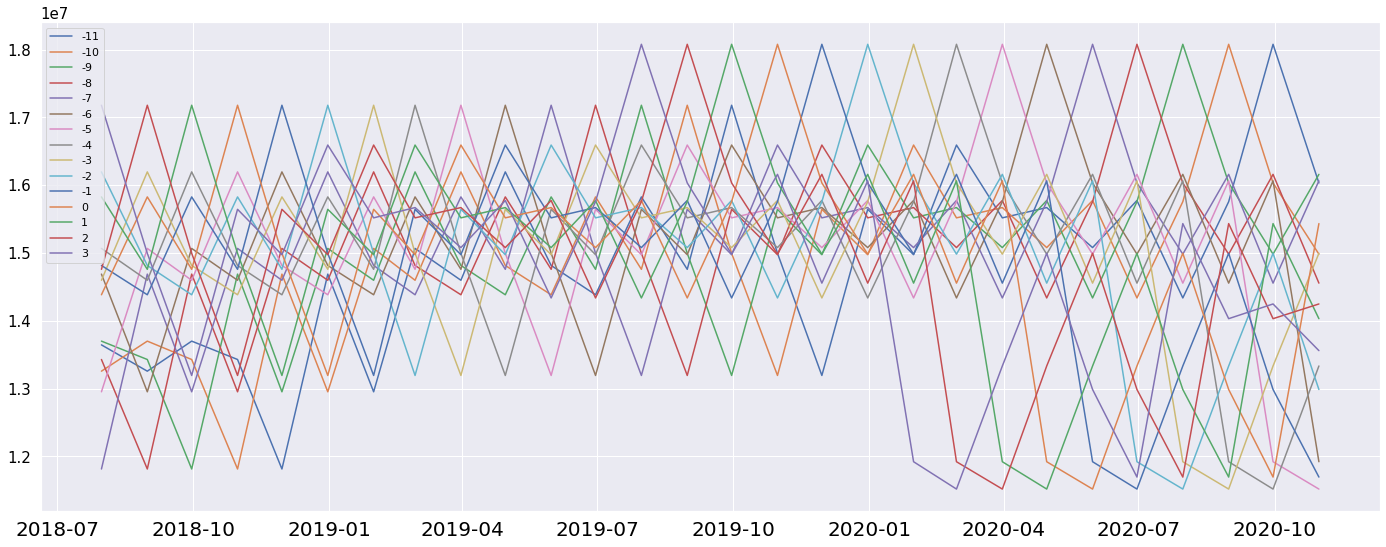

In [156]:
# plot the example time series
!pip install seaborn
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# sns.set_context('paper', font_scale=1.3)
# sns.set_style('white')

(fig, ax) = plt.subplots(figsize=(24, 9))
import matplotlib.pyplot as plt
whole_data = train.copy()
target_label = target_column_name
whole_data[target_label] = train[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):
    plt.plot(g[1][time_column_name].values,
             g[1][target_column_name].values, label=g[0])
plt.legend()
plt.show()

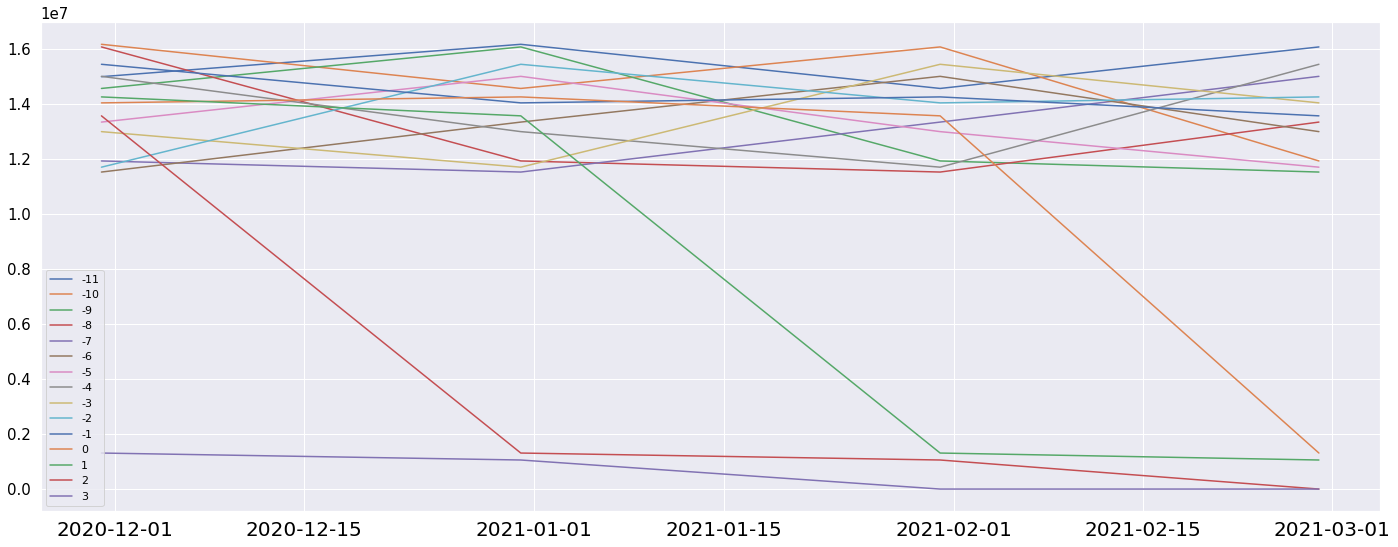

In [157]:
# plot the example time series

(fig, ax) = plt.subplots(figsize=(24, 9))
import matplotlib.pyplot as plt
whole_data = test.copy()
target_label = target_column_name
whole_data[target_label] = test[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):
    plt.plot(g[1][time_column_name].values,
             g[1][target_column_name].values, label=g[0])
plt.legend()
plt.show()

In [158]:
datastore = ws.get_default_datastore()
datastore
datastore.upload_files(files=[output_data_path + './revtime_train.csv',
                       output_data_path + './revtime_test.csv'],
                       target_path='merge_final/', overwrite=True,
                       show_progress=True)

Uploading an estimated of 2 files
Uploading ./output-data/./revtime_train.csv
Uploaded ./output-data/./revtime_train.csv, 1 files out of an estimated total of 2
Uploading ./output-data/./revtime_test.csv
Uploaded ./output-data/./revtime_test.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_1ba247d1c6ab432089212a018762bf9e

In [159]:
# Create dataset for training

from azureml.core.dataset import Dataset
train_dataset = \
    Dataset.Tabular.from_delimited_files(path=datastore.path('merge_final/revtime_train.csv'
        ))

display(train_dataset.to_pandas_dataframe().head())
display(train_dataset.to_pandas_dataframe().tail())


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
0,2018-07-31,-31,2017-08-31,-42,13644814,12932411,13533999,13422283,13184530,-11,13644814,0,6762094,0,0,519,2471.6500
1,2018-08-31,-30,2017-09-30,-41,13257051,12904745,13462141,13306936,13028858,-11,13257051,0,4530171,0,0,519,2519.3600
2,2018-09-30,-29,2017-10-31,-40,13700136,13534001,12981147,13608661,13237306,-11,13700132,0,6782319,0,0,539,2575.2600
3,2018-10-31,-28,2017-11-30,-39,13429238,13462142,13310566,13758270,13197277,-11,13429239,0,7408248,0,0,548,2647.5800
4,2018-11-30,-27,2017-12-31,-38,11814068,12981147,13151732,14219427,12942946,-11,11814066,0,4170817,0,0,531,2673.6100


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
415,2020-06-30,-8,2020-09-30,-5,12061956,13732828,9509466,6154179,12988861,3,11695095,33449833,10437439,32049434,10683144,584,3363.0000
416,2020-07-31,-7,2020-10-31,-4,12036730,13564901,8255915,5212469,13381783,3,15433514,49435025,14536849,35050408,11683469,579,3269.9600
417,2020-08-31,-6,2020-11-30,-3,9545051,12421403,6576357,4390583,13109913,3,14031331,35118793,9928454,35824284,11941428,576,3621.6300
418,2020-09-30,-5,2020-12-31,-2,8649836,12194316,6640645,4659048,12655965,3,14248280,27136284,17927536,38679414,12893138,530,3756.0700
419,2020-10-31,-4,2021-01-31,-1,10241939,12797947,7860320,5428734,13101303,3,13560107,25882792,14446751,0,0,531,3714.2400


In [160]:
# Featurization Customization examples
'''
featurization_config = FeaturizationConfig()
featurization_config.drop_columns = ['Monthly_Return',
        'sp500_1M_Previous']

# Force the CPWVOL5 feature to be numeric type.
# featurization_config.add_column_purpose('CPWVOL5', 'Numeric')
# Fill missing values in the target column, Revenue, with zeros.

featurization_config.add_transformer_params('Imputer',
        [target_column_name], {'strategy': 'constant', 'fill_value': 0})

# Fill missing values in the Current Opp Period Value column with median value.

featurization_config.add_transformer_params('Imputer',
        ['Current_Opp._Period_Value'], {'strategy': 'median'})
featurization_config.add_transformer_params('Imputer', ['Conversions'],
        {'strategy': 'median'})

# Fill missing values in the sp500 column with forward fill (last value carried forward).

featurization_config.add_transformer_params('Imputer', ['sp500'],
        {'strategy': 'ffill'})
featurization_config.add_transformer_params('Imputer', ['Headcount'],
        {'strategy': 'ffill'})
featurization_config.add_transformer_params('Imputer',
        ['Headcount_Contingent'], {'strategy': 'ffill'})
'''

"\nfeaturization_config = FeaturizationConfig()\nfeaturization_config.drop_columns = ['Monthly_Return',\n        'sp500_1M_Previous']\n\n# Force the CPWVOL5 feature to be numeric type.\n# featurization_config.add_column_purpose('CPWVOL5', 'Numeric')\n# Fill missing values in the target column, Revenue, with zeros.\n\nfeaturization_config.add_transformer_params('Imputer',\n        [target_column_name], {'strategy': 'constant', 'fill_value': 0})\n\n# Fill missing values in the Current Opp Period Value column with median value.\n\nfeaturization_config.add_transformer_params('Imputer',\n        ['Current_Opp._Period_Value'], {'strategy': 'median'})\nfeaturization_config.add_transformer_params('Imputer', ['Conversions'],\n        {'strategy': 'median'})\n\n# Fill missing values in the sp500 column with forward fill (last value carried forward).\n\nfeaturization_config.add_transformer_params('Imputer', ['sp500'],\n        {'strategy': 'ffill'})\nfeaturization_config.add_transformer_params('I

In [161]:
# Train

from azureml.automl.core.forecasting_parameters import ForecastingParameters
lags = 'auto'  # [x for x in range(1,7)]
print ('lags: ', lags)
window_size = 'auto'
forecast_horizon = n_test_periods
print ('window_size: ', window_size, ' forecast_horizon: ',
       forecast_horizon)
forecasting_parameters = ForecastingParameters(  # ,
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    time_series_id_column_names=time_series_id_column_names,
    target_lags=lags,
    feature_lags='auto',
    target_rolling_window_size=window_size,
    )

    # drop_column_names = ['-1M Pipeline']

automl_config = AutoMLConfig(  # featurization_config,
    task='forecasting',
    debug_log='rev_forecast_errors.log',
    primary_metric='normalized_root_mean_squared_error',
    experiment_timeout_hours=4,
    training_data=train_dataset,
    label_column_name=target_column_name,
    compute_target=compute_target,
    enable_early_stopping=True,
    featurization='auto',
    n_cross_validations=5,
    verbosity=logging.INFO,
    max_concurrent_iterations=4,
    max_cores_per_iteration=-1,
    enable_dnn=True,
    forecasting_parameters=forecasting_parameters,
    )

lags:  auto
window_size:  auto  forecast_horizon:  4


In [162]:
# submit a new training run
#'''
remote_run = experiment.submit(automl_config, show_output=True)
remote_run
#'''

Running on remote.
No run_configuration provided, running on cc-bi-ml-devqa01 with default configuration
Running on remote compute: cc-bi-ml-devqa01
Parent Run ID: AutoML_06fb94f2-fa83-418d-b411-fc583f0fae09

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: ModelSelection. Beginning model selection.
Heuristic parameters: Target_Lag = '[1]', Target_Rolling_Window = '4'.


****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.
              

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were

Experiment,Id,Type,Status,Details Page,Docs Page
revenue-time-forecast1,AutoML_06fb94f2-fa83-418d-b411-fc583f0fae09,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [163]:
# If you need to retrieve a run that already started, use the following code
'''
from azureml.train.automl.run import AutoMLRun
remote_run = AutoMLRun(experiment=experiment,
                       run_id='AutoML_710b9cb4-47dd-4227-ac43-5c1ad2a5ae9e' 
                       )
'''                   

"\nfrom azureml.train.automl.run import AutoMLRun\nremote_run = AutoMLRun(experiment=experiment,\n                       run_id='AutoML_710b9cb4-47dd-4227-ac43-5c1ad2a5ae9e' \n                       )\n"

In [164]:
remote_run.wait_for_completion()

{'runId': 'AutoML_06fb94f2-fa83-418d-b411-fc583f0fae09',
 'target': 'cc-bi-ml-devqa01',
 'status': 'Completed',
 'startTimeUtc': '2021-02-11T00:41:43.071286Z',
 'endTimeUtc': '2021-02-11T01:11:52.547736Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'cc-bi-ml-devqa01',
  'AMLSettingsJsonString': '{"path":null,"name":"revenue-time-forecast1","subscription_id":"db61fd47-db56-45e3-844f-1b1f5c47990a","resource_group":"rg-bi-automl-devqa01","workspace_name":"mlw-bi-automl-devqa01","region":"westus","compute_target":"cc-bi-ml-devqa01","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"normalized_root_mean_squared_error","task_type":"regression","data_script":null,"validation_size":0.0,"n_cross_v

In [165]:
# Retrieve the Best Model

(best_run, fitted_model) = remote_run.get_output()
print ('Best Run Model: ', best_run)
print (fitted_model.steps)
model_name = best_run.properties['model_name']
print ('Model Name: ', model_name)

Package:azureml-automl-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-core, training version:1.21.0.post1, current version:1.20.0
Package:azureml-dataprep, training version:2.8.2, current version:2.7.3
Package:azureml-dataprep-native, training version:28.0.0, current version:27.0.0
Package:azureml-dataprep-rslex, training version:1.6.0, current version:1.5.0
Package:azureml-dataset-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-defaults, training version:1.21.0, current version:1.20.0
Package:azureml-interpret, training version:1.21.0, current version:1.20.0
Package:azureml-pipeline-core, training version:1.21.0, current version:1.20.0
Package:azureml-telemetry, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-client, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-runtime, training version:1.21.0, current version:1.20.0


Best Run Model:  Run(Experiment: revenue-time-forecast1,
Id: AutoML_06fb94f2-fa83-418d-b411-fc583f0fae09_548,
Type: azureml.scriptrun,
Status: Completed)
[('timeseriestransformer', TimeSeriesTransformer(featurization_config=None,
                      pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('531',
                                          Pipeline(memory=None,
                                                   steps=[('maxabsscaler',
                                                           MaxAbsScaler(copy=True)),
                                                          ('randomforestregressor',
                                                           RandomForestRegressor(bootstrap=False,
                                                                                 ccp_alpha=0.0,
                                                                                 criterion='mse',
                

In [166]:
# Transparency
# View updated featurization summary

featurization_summary = fitted_model.named_steps['timeseriestransformer'
        ].get_featurization_summary()

# View the featurization summary as a pandas dataframe

pd.DataFrame.from_records(featurization_summary)


,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,Billable_Headcount,Numeric,No,10,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag]"
1,Conversions,Numeric,No,10,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag]"
2,Current_Opp._Period_Value,Numeric,No,4,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag]"
3,End_of_Month,Numeric,No,10,"[MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer]"
4,Pipeline,Numeric,No,25,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag]"
5,Pipeline_3M_Forward_Avg,Numeric,No,3,"[MedianImputer, ImputationMarker, MedianImputer-Lag]"
6,Pipeline_3_Month_Rolling_Avg,Numeric,No,2,"[MedianImputer, ImputationMarker]"
7,Pipeline_6M_Forward_Avg,Numeric,No,2,"[MedianImputer, ImputationMarker]"
8,Pipeline_6M_Rolling_Avg,Numeric,No,2,"[MedianImputer, ImputationMarker]"
9,Pipeline_Trend,Numeric,No,7,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag]"


In [167]:
# Explore the results

from azureml.widgets import RunDetails
RunDetails(best_run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [168]:
best_run.wait_for_completion()

{'runId': 'AutoML_06fb94f2-fa83-418d-b411-fc583f0fae09_548',
 'target': 'cc-bi-ml-devqa01',
 'status': 'Completed',
 'startTimeUtc': '2021-02-11T01:09:26.679776Z',
 'endTimeUtc': '2021-02-11T01:11:25.803576Z',
 'properties': {'runTemplate': 'automl_child',
  'pipeline_id': '__AutoML_Ensemble__',
  'pipeline_spec': '{"pipeline_id":"__AutoML_Ensemble__","objects":[{"module":"azureml.train.automl.ensemble","class_name":"Ensemble","spec_class":"sklearn","param_args":[],"param_kwargs":{"automl_settings":"{\'task_type\':\'regression\',\'primary_metric\':\'normalized_root_mean_squared_error\',\'verbosity\':20,\'ensemble_iterations\':15,\'is_timeseries\':True,\'name\':\'revenue-time-forecast1\',\'compute_target\':\'cc-bi-ml-devqa01\',\'subscription_id\':\'db61fd47-db56-45e3-844f-1b1f5c47990a\',\'region\':\'westus\',\'time_column_name\':\'Snapshot_Date_Short\',\'grain_column_names\':[\'Relative_Offset\'],\'max_horizon\':4,\'drop_column_names\':[],\'spark_service\':None}","ensemble_run_id":"Auto

In [170]:
from azureml.interpret import ExplanationClient
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
print(engineered_explanations.get_feature_importance_dict())
print("You can visualize the engineered explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n" + best_run.get_portal_url())
raw_explanations = client.download_model_explanation(raw=True)
print(raw_explanations.get_feature_importance_dict())
print("You can visualize the raw explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n" + best_run.get_portal_url())

{'Pipeline': 823795.1587323203, 'Relative_Month_Offset': 330826.5263779456, 'Conversions': 148184.58565926866, 'Billable_Headcount': 52956.72870319715, 'Pipeline_Trend': 50956.782522173125, 'Current_Opp._Period_Value': 38184.85225446905, 'Pipeline_6M_Forward_Avg': 34650.89658951139, 'End_of_Month_DayOfYear': 32858.57646453672, 'End_of_Month_DayOfWeek': 30797.644339871553, 'sp500': 20834.223291098122, 'Pipeline_3M_Forward_Avg': 13583.395244013624, 'Pipeline_3_Month_Rolling_Avg': 12276.315344780387, 'Pipeline_6M_Rolling_Avg_lag6M': 11656.34703933448, 'Pipeline_6M_Rolling_Avg': 6826.423166232987, 'Pipeline_6M_Forward_Avg_lag3M': 6288.790438499822, 'Pipeline_6M_Forward_Avg_lag7M': 5673.449470068354, 'Pipeline_6M_Rolling_Avg_lag7M': 5289.926807100085, 'Pipeline_6M_Forward_Avg_lag5M': 4945.068921272481, '_automl_wday': 4939.968079020394, 'Pipeline_6M_Forward_Avg_lag4M': 3521.534751292924, 'sp500_lag3M': 3376.9771495262044, 'Pipeline_6M_Rolling_Avg_lag4M': 3316.905555503689, '_automl_qday': 3

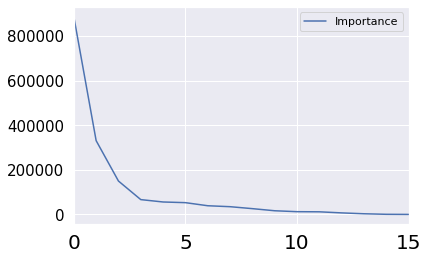

In [171]:
feature_imp_dict = pd.DataFrame(raw_explanations.get_feature_importance_dict().items())
feature_imp_dict.columns = ['Feature','Importance']
feature_imp_dict.plot()

In [172]:
# multiple line plot
# Set themes

import matplotlib.pyplot as plt

# plot

sns.set()
sns.set_context('poster')  # In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style='whitegrid')  # Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks.

# Save a palette to a variable:

palette = sns.color_palette('Accent', 8)

# Use palplot and pass in the variable:
# sns.palplot(palette)
# Set the palette using the name of a palette:
# sns.set_palette(palette)
bg_color = 'white'
sns.set(rc={"font.style":"normal",
            #"axes.facecolor":bg_color,
            #"figure.facecolor":bg_color,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':25,
            'figure.figsize':(12.0, 8.0),
            'xtick.labelsize':20,
            'font.size':15,
            'ytick.labelsize':15})

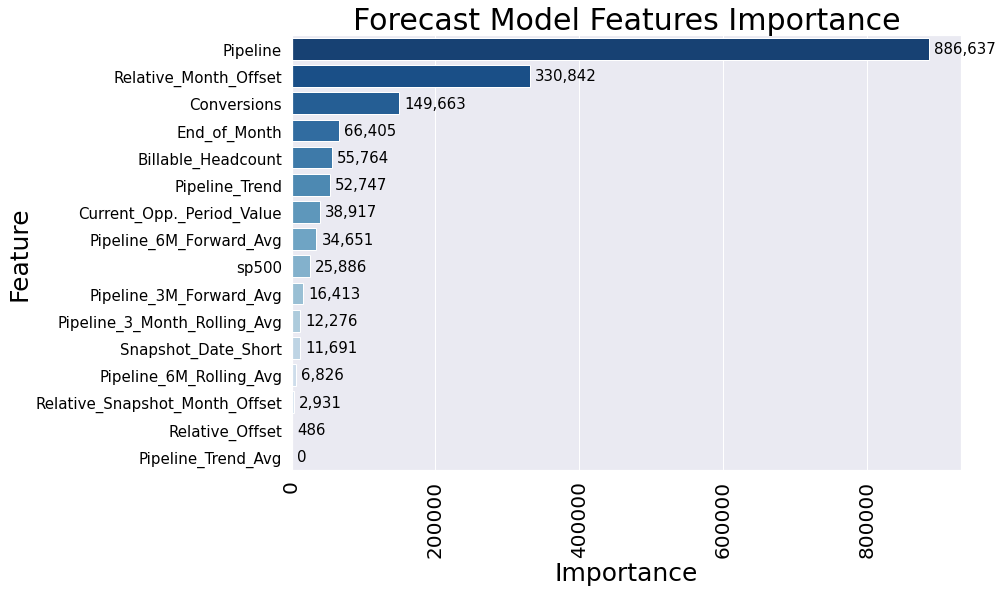

In [173]:
#(fig, ax) = plt.subplots(figsize=(24, 9))
g = sns.barplot(   #alpha=0.50,
    y='Feature',
    x='Importance',
    ci=None,
    data=feature_imp_dict,
    #color='skyblue'
    #orient='horizontal'
    palette='Blues_r',
    #ax=ax,
    )
plt.xticks(rotation=90)
plt.title('Forecast Model Features Importance', fontsize=30)
for p in g.patches:
    g.annotate(
        '{:,.0f}'.format(p.get_width()),
        xy=(p.get_width(), p.get_y() + p.get_height()/2),
        ha='left',
        va='center',
        xytext=(5, 0),
        #color = 'white',
        textcoords='offset points',
        )
#g.legend(['Revenue', 'Forecast'], facecolor='w')
plt.show()

In [174]:
# FORECASTING

X_test = test.copy()
y_test = X_test.pop(target_column_name).values

In [175]:
X_test.tail()

,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
478,2021-02-28,0,2021-04-30,2,12747300,14678852,9541139,7065487,14312713,2,0,0,0,0,516,nan
434,2020-11-30,-3,2021-02-28,0,10767529,12739385,9035550,6061625,13248106,3,7253328,4075810,41025314,13675104,525,3911.2300
449,2020-12-31,-2,2021-03-31,1,13708009,14299268,9529502,6618171,14363980,3,0,0,0,0,521,nan
464,2021-01-31,-1,2021-04-30,2,12142675,14418292,8835313,6143830,14227007,3,0,0,0,0,516,nan
479,2021-02-28,0,2021-05-31,3,8288733,12906128,7074768,5450446,13355613,3,0,0,0,0,516,nan


In [176]:
# forecast returns the predictions and the featurized data, aligned to X_test.
# This contains the assumptions that were made in the forecast
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data

y_predictions, X_trans = fitted_model.forecast(X_test)

In [177]:
# from forecasting_helper import align_outputs

df_all = align_outputs(y_predictions, X_trans, X_test, y_test,
                       target_column_name)
df_all.tail(20)

,Snapshot_Date_Short,Relative_Offset,origin,predicted,horizon_origin,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500,Revenue
40,2020-11-30,-1,2020-10-31,14822730.1872,1,-3,2020-10-31,-4,15433515,13371811,14064246,12935240,13327101,49435025,14536849,35050408,11683469,579,3269.9600,15433514
41,2020-12-31,-1,2020-10-31,13215240.0614,2,-2,2020-11-30,-3,14031333,13719981,14366161,13225398,13745966,35118793,9928454,35824284,11941428,576,3621.6300,14031331
42,2021-01-31,-1,2020-10-31,14203715.3474,3,-1,2020-12-31,-2,14248282,14571044,13834612,13167947,13898420,27136284,17927536,38679414,12893138,530,3756.0700,14248280
43,2021-02-28,-1,2020-10-31,13845873.7502,4,0,2021-01-31,-1,13560108,13946575,14949788,12245463,13659193,25882792,14446751,0,0,531,3714.2400,13560107
44,2020-11-30,0,2020-10-31,13206419.0129,1,-3,2020-11-30,-3,14141869,13756827,13864165,11449858,13764388,35118793,9928454,35824284,11941428,576,3621.6300,14031331
45,2020-12-31,0,2020-10-31,14196472.0091,2,-2,2020-12-31,-2,13821226,14428692,14337007,11933255,13827244,27136284,17927536,38679414,12893138,530,3756.0700,14248280
46,2021-01-31,0,2020-10-31,13921998.2371,3,-1,2021-01-31,-1,13827550,14035722,14979917,11907615,13703766,25882792,14446751,0,0,531,3714.2400,13560107
47,2021-02-28,0,2020-10-31,13029197.0694,4,0,2021-02-28,0,13606905,13805098,14678852,10876810,13762540,7253328,4075810,41025314,13675104,525,3911.2300,1308770
48,2020-11-30,1,2020-10-31,13959926.3608,1,-3,2020-12-31,-2,12617353,14064246,12739385,9666935,13645021,27136284,17927536,38679414,12893138,530,3756.0700,14248280
49,2020-12-31,1,2020-10-31,14397378.1757,2,-2,2021-01-31,-1,15245924,14366161,14299268,10516867,13868986,25882792,14446751,0,0,531,3714.2400,13560107


In [178]:
# Evaluate
# To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE).

# We'll add predictions and actuals into a single dataframe for convenience in calculating the metrics.

# assign_dict = {'predicted': y_predictions, target_column_name: y_test}
# df_all = X_test.assign(**assign_dict)
# df_all

[Test data scores]
explained_variance:   0.073
normalized_root_mean_squared_error:   0.325
mean_absolute_percentage_error:   133.380
root_mean_squared_error:   5257519.823
median_absolute_error:   104438.960
normalized_median_absolute_error:   0.006
spearman_correlation:   0.710
root_mean_squared_log_error:   3.761
mean_absolute_error:   2312340.997
normalized_mean_absolute_error:   0.143
normalized_root_mean_squared_log_error:   0.227
r2_score:   -0.097


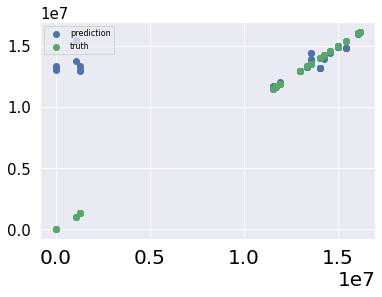

In [179]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module

scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print('[Test data scores]')
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs

%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

In [180]:
df_all.groupby('horizon_origin').apply(lambda df: \
        pd.Series({'MAPE': MAPE(df[target_column_name], df['predicted'
        ]), 'RMSE': np.sqrt(mean_squared_error(df[target_column_name],
        df['predicted'])),
        'MAE': mean_absolute_error(df[target_column_name],
        df['predicted'])}))

,MAPE,RMSE,MAE
horizon_origin,,,
1,63.0052,3139157.8404,1014715.0583
2,141.3230,4479746.7237,1812984.2021
3,162.0664,5904770.3580,2779805.5399
4,174.5225,6765892.6326,3641859.1889


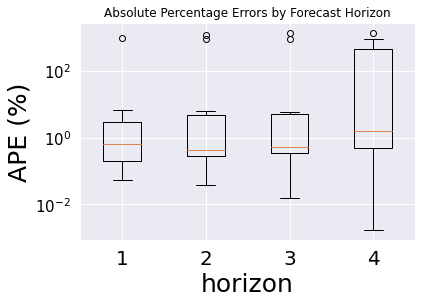

In [181]:
df_all_APE = df_all.assign(APE=APE(df_all[target_column_name], df_all['predicted']))
APEs = [df_all_APE[df_all['horizon_origin'] == h].APE.values for h in range(1, forecast_horizon + 1)]

%matplotlib inline
plt.boxplot(APEs)
plt.yscale('log')
plt.xlabel('horizon')
plt.ylabel('APE (%)')
plt.title('Absolute Percentage Errors by Forecast Horizon')

plt.show()

In [182]:
# Confidence intervals

quantiles =  fitted_model.forecast_quantiles(X_test)
quantiles

,Snapshot_Date_Short,Relative_Offset,0.5
0,2020-11-30,-11,15030485.3420
1,2020-12-31,-11,16165851.4899
2,2021-01-31,-11,14531439.7395
3,2021-02-28,-11,16063775.1480
4,2020-11-30,-10,16143051.1280
5,2020-12-31,-10,14495923.5306
6,2021-01-31,-10,16046927.9410
7,2021-02-28,-10,12034964.8048
8,2020-11-30,-9,14449800.0152
9,2020-12-31,-9,16000126.6284


In [183]:
# specify which quantiles you would like 

fitted_model.quantiles = [0.01, 0.5, 0.8, 0.95]

# use forecast_quantiles function, not the forecast() one

y_pred_quantiles =  fitted_model.forecast_quantiles(X_test)

# quantile forecasts returned in a Dataframe along with the time and time series id columns 

y_pred_quantiles

,Snapshot_Date_Short,Relative_Offset,0.01,0.5,0.8,0.95
0,2020-11-30,-11,13814785.8751,15030485.3420,15470298.5343,15890050.5427
1,2020-12-31,-11,14841579.5935,16165851.4899,16644943.7871,17102183.2639
2,2021-01-31,-11,13246398.1966,14531439.7395,14996339.3620,15440033.5342
3,2021-02-28,-11,14658631.1900,16063775.1480,16572125.1693,17057287.8387
4,2020-11-30,-10,14927351.6612,16143051.1280,16582864.3204,17002616.3288
5,2020-12-31,-10,13171651.6342,14495923.5306,14975015.8278,15432255.3046
6,2021-01-31,-10,14761886.3981,16046927.9410,16511827.5635,16955521.7357
7,2021-02-28,-10,10629820.8468,12034964.8048,12543314.8261,13028477.4955
8,2020-11-30,-9,13234100.5484,14449800.0152,14889613.2076,15309365.2160
9,2020-12-31,-9,14675854.7320,16000126.6284,16479218.9255,16936458.4023


In [184]:
# Get the column index list in the right order

cols_sort_list = list(df_all.columns) + ['Revenue_Forecast']
display(cols_sort_list)
display(df_all)

['Snapshot_Date_Short',
 'Relative_Offset',
 'origin',
 'predicted',
 'horizon_origin',
 'Relative_Snapshot_Month_Offset',
 'End_of_Month',
 'Relative_Month_Offset',
 'Pipeline',
 'Pipeline_3_Month_Rolling_Avg',
 'Pipeline_3M_Forward_Avg',
 'Pipeline_6M_Forward_Avg',
 'Pipeline_6M_Rolling_Avg',
 'Current_Opp._Period_Value',
 'Conversions',
 'Pipeline_Trend',
 'Pipeline_Trend_Avg',
 'Billable_Headcount',
 'sp500',
 'Revenue',
 'Revenue_Forecast']

,Snapshot_Date_Short,Relative_Offset,origin,predicted,horizon_origin,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500,Revenue
0,2020-11-30,-11,2020-10-31,15030485.3420,1,-3,2019-12-31,-14,14983141,16364927,15232938,14200388,15827166,31827707,10200225,43364151,14454717,590,3230.7800,14983139
1,2020-12-31,-11,2020-10-31,16165851.4899,2,-2,2020-01-31,-13,16159870,15725440,15593239,13925457,15891444,39178128,18296228,45089679,15029893,600,3225.5200,16159868
2,2021-01-31,-11,2020-10-31,14531439.7395,3,-1,2020-02-29,-12,14555802,15232938,14180392,13731391,15927887,43379196,8213853,43443552,14481184,596,2954.2200,14555799
3,2021-02-28,-11,2020-10-31,16063775.1480,4,0,2020-03-31,-11,16064045,15593239,13167839,13469894,15979083,32366818,23581425,37552231,12517410,584,2584.5900,16064043
4,2020-11-30,-10,2020-10-31,16143051.1280,1,-3,2020-01-31,-13,16159870,15725440,15593239,13925457,15891444,39178128,18296228,45089679,15029893,600,3225.5200,16159868
5,2020-12-31,-10,2020-10-31,14495923.5306,2,-2,2020-02-29,-12,14555802,15232938,14180392,13731391,15927887,43379196,8213853,43443552,14481184,596,2954.2200,14555799
6,2021-01-31,-10,2020-10-31,16046927.9410,3,-1,2020-03-31,-11,16064045,15593239,13167839,13469894,15979083,32366818,23581425,37552231,12517410,584,2584.5900,16064043
7,2021-02-28,-10,2020-10-31,12034964.8048,4,0,2020-04-30,-10,11921328,14180392,12257676,12741736,14952916,38003379,10343606,35222782,11740927,585,2912.4300,11921327
8,2020-11-30,-9,2020-10-31,14449800.0152,1,-3,2020-02-29,-12,14555802,15232938,14180392,13731391,15927887,43379196,8213853,43443552,14481184,596,2954.2200,14555799
9,2020-12-31,-9,2020-10-31,16000126.6284,2,-2,2020-03-31,-11,16064045,15593239,13167839,13469894,15979083,32366818,23581425,37552231,12517410,584,2584.5900,16064043


In [185]:
# Merge df_all with train

from functools import reduce

nan_value = 0
merge_dfs = [train, df_all]

final_merge_df = train.append(df_all,
                              ignore_index=True).sort_values(by=sort_cols)
coerce_df_columns_to_numeric(final_merge_df)

final_merge_df = final_merge_df.replace(np.nan, 0, regex=True)

# merge_df = merge_df.query('Fin_Entity_ID!='SGP'') # Exclude Singapore rows
# final_merge_df.sort_values(by=['Relative_Offset','Fin_Entity_ID']).reset_index(drop=True) and Relative_Month_Offset >= 0
# merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)
# create new column

final_merge_df['Revenue_Forecast'] = np.where(final_merge_df['predicted'
        ] != 0, final_merge_df['predicted'], final_merge_df['Revenue'])
final_merge_df['Relative_Month_Offset'] = \
    round((final_merge_df['End_of_Month'] - current_eom)
          / np.timedelta64(1, 'M'), 0).astype(int)
final_merge_df['End_of_Month'] = \
    pd.to_datetime(final_merge_df['End_of_Month']).dt.date

final_merge_df['origin'] = pd.to_datetime(final_merge_df['origin'
        ]).dt.date

final_merge_df['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df['Snapshot_Date_Short']).dt.date
# sort using original cols_sort_list
final_merge_df = \
    final_merge_df.sort_values(by=sort_cols).reset_index(drop=True)
final_merge_df = final_merge_df.reindex(columns=cols_sort_list)

# add revenue vs predicted variance
final_merge_df['Diff'] = final_merge_df['Revenue'] - final_merge_df['predicted']
final_merge_df['Diff%'] = round(final_merge_df['Diff'] / final_merge_df['predicted'] * 100, ndigits=4)

print(' final_merge_df: ')

final_merge_df.to_csv(output_data_path + 'final_merge_df.csv',
                      index=False)
final_merge_df.to_parquet(output_data_path + 'final_merge_df.parquet',
                          index=None)
#show_stats(final_merge_df)
display(final_merge_df)
#final_merge_df  # .query('Fin_Entity_ID==@entity_debug')

 final_merge_df: 


,Snapshot_Date_Short,Relative_Offset,origin,predicted,horizon_origin,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500,Revenue,Revenue_Forecast,Diff,Diff%
0,2018-07-31,-11,1970-01-01,0,0,-31,2017-08-31,-42,13644814,12932411,13533999,13422283,13184530,0,6762094,0,0,519,2471.6500,13644814,13644814,13644814,inf
1,2018-07-31,-10,1970-01-01,0,0,-31,2017-09-30,-41,13257051,12904745,13462141,13306936,13028858,0,4530171,0,0,519,2519.3600,13257051,13257051,13257051,inf
2,2018-07-31,-9,1970-01-01,0,0,-31,2017-10-31,-40,13700132,13533999,12981146,13608660,13237305,0,6782319,0,0,539,2575.2600,13700132,13700132,13700132,inf
3,2018-07-31,-8,1970-01-01,0,0,-31,2017-11-30,-39,13429239,13462141,13310566,13758270,13197276,0,7408248,0,0,548,2647.5800,13429239,13429239,13429239,inf
4,2018-07-31,-7,1970-01-01,0,0,-31,2017-12-31,-38,11814066,12981146,13151731,14219427,12942945,0,4170817,0,0,531,2673.6100,11814066,11814066,11814066,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2021-02-28,-1,2020-10-31,13845873,4,0,2021-01-31,-1,13560108,13946575,14949788,12245463,13659193,25882792,14446751,0,0,531,3714.2400,13560107,13845873,-285766,-2.0639
476,2021-02-28,0,2020-10-31,13029197,4,0,2021-02-28,0,13606905,13805098,14678852,10876810,13762540,7253328,4075810,41025314,13675104,525,3911.2300,1308770,13029197,-11720427,-89.9551
477,2021-02-28,1,2020-10-31,15371748,4,0,2021-03-31,1,17682351,14949788,12906128,9392031,14760416,0,0,0,0,521,0.0000,1055739,15371748,-14316009,-93.1320
478,2021-02-28,2,2020-10-31,13013327,4,0,2021-04-30,2,12747300,14678852,9541139,7065487,14312713,0,0,0,0,516,0.0000,0,13013327,-13013327,-100.0000


In [186]:
# pivot by EOM1, Fin_Entity_ID
pd.set_option('display.float_format', lambda x: '%.1f' % x) #


cols = ['Pipeline','Revenue','predicted','Diff','Diff%']
final_merge_pivot1 = final_merge_df.query('Relative_Offset >= -@relative_offset_periods and Relative_Snapshot_Month_Offset >= -1').pivot_table(index=['Snapshot_Date_Short','End_of_Month'], #columns='Relative_Offset',
        values=cols, aggfunc={'predicted':np.sum,'Pipeline':np.sum,'Revenue':np.sum,'Diff':np.sum, 'Diff%':np.mean}, margins=None)
#final_merge_pivot1 = \
#    final_merge_pivot1['End_of_Month'] = pd.to_datetime(final_merge_pivot1['End_of_Month']).dt.date
# final_merge_pivot1.reset_index(level=final_merge_pivot1.index.names)

# show_stats(revtime_pivot1)
final_merge_pivot1.sort_values(by=sort_cols,inplace=True)
#reorder columns
cols_order = [2,3,4,0,1]
final_merge_pivot1 = final_merge_pivot1[[final_merge_pivot1.columns[i] for i in cols_order]]

# set ALL float columns to '${:,.2f}' formatting (including the percentage)
#format_dict = {col_name: '${:,.1f}' for col_name in final_merge_pivot1.select_dtypes(float).columns}
# override the percentage column
format_dict = {col_name: '{:,}' for col_name in final_merge_pivot1.columns}
format_dict['Diff%'] = '{:.2f}'


# Format with commas and round off to two decimal places in pandas 
# final_merge_pivot1 = final_merge_pivot1[[['Snapshot_Date_Short','End_of_Month']+cols]]
final_merge_pivot1.style.format(format_dict)#.style.format('{:,}')# .query('(End_of_Month == @current_eom)')

In [187]:
!pip install xlsxwriter
import xlsxwriter
final_merge_pivot1.tail(28).to_excel(output_data_path + r'./revenue-prediction.xlsx', \
             sheet_name=str(today.date()), header=True, engine='xlsxwriter')  

In [188]:
# multiple line plot
# Set themes

import matplotlib.pyplot as plt

# plot

sns.set()
sns.set_context('poster')  # In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style='whitegrid')  # Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks.

# Save a palette to a variable:

palette = sns.color_palette('Accent', 8)

# Use palplot and pass in the variable:
# sns.palplot(palette)
# Set the palette using the name of a palette:
# sns.set_palette(palette)

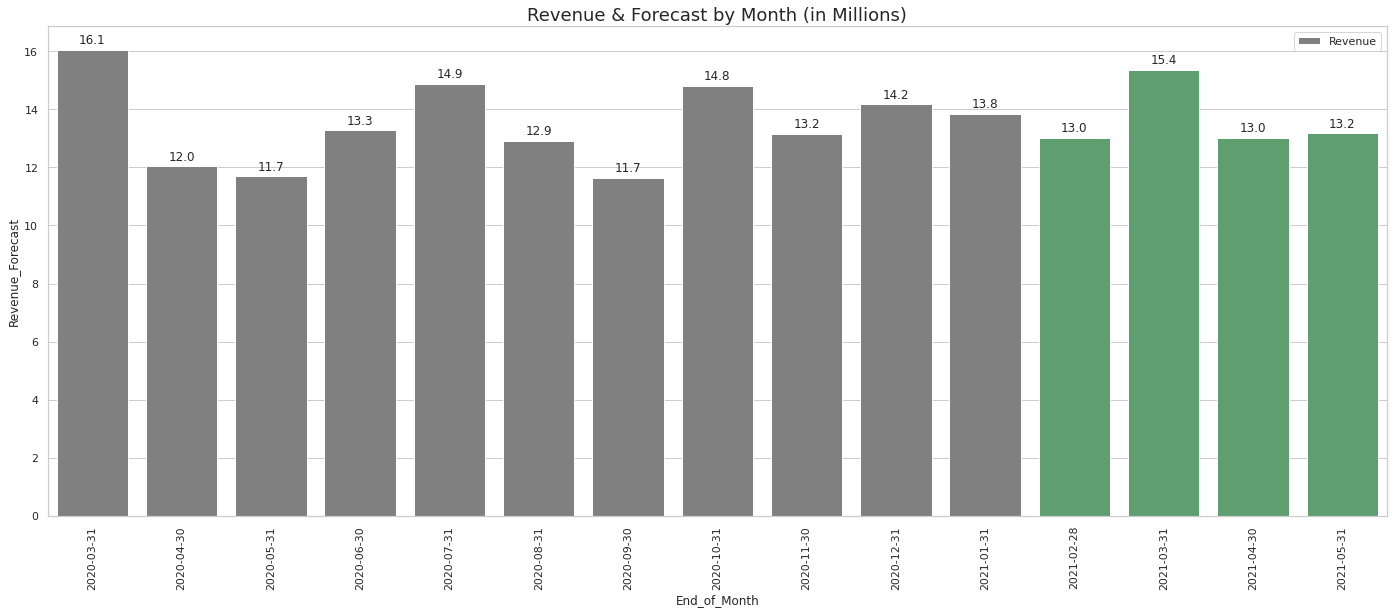

In [189]:
# Bar plot for history and forecast revenues summary by month

(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset == 0').copy()
# final_merge_df1['Date'] = pd.to_datetime(final_merge_df1['End_of_Month'
#         ]).dt.date  # .astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.barplot(  # alpha=0.50,
    x='End_of_Month',
    y='Revenue_Forecast',
    ci=None,
    data=final_merge_df1,
    palette=clrs,
    ax=ax,
    )
plt.xticks(rotation=90)
plt.title('Revenue & Forecast by Month (in Millions)', fontsize=18)
for p in g.patches:
    g.annotate(
        '{:,.1f}'.format(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        )
g.legend(['Revenue', 'Forecast'], facecolor='w')
plt.show()

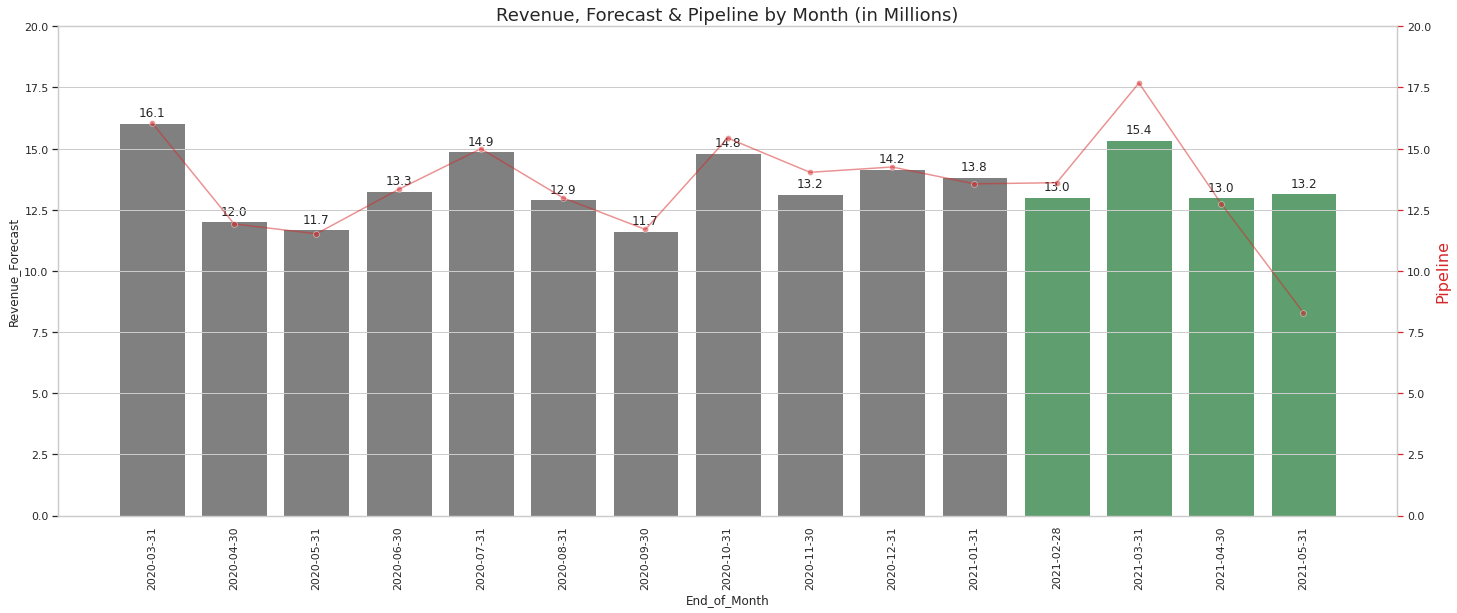

In [190]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

(fig, ax1) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset == 0').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.barplot(  # alpha=0.50,
    x='End_of_Month',
    y='Revenue_Forecast',
    ci=None,
    data=final_merge_df1,
    palette=clrs,
    ax=ax1,
    )
plt.xticks(rotation=90)
plt.ylim(0,20)
plt.title('Revenue, Forecast & Pipeline by Month (in Millions)', fontsize=18)
for p in g.patches:
    g.annotate(
        '{:,.1f}'.format(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        )
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax1.twinx()
color='tab:red'
ax2.set_ylabel('Pipeline', fontsize=16, color=color)
g = sns.lineplot(
    x='End_of_Month',
    y='Pipeline',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
plt.ylim(0,20)
plt.show()

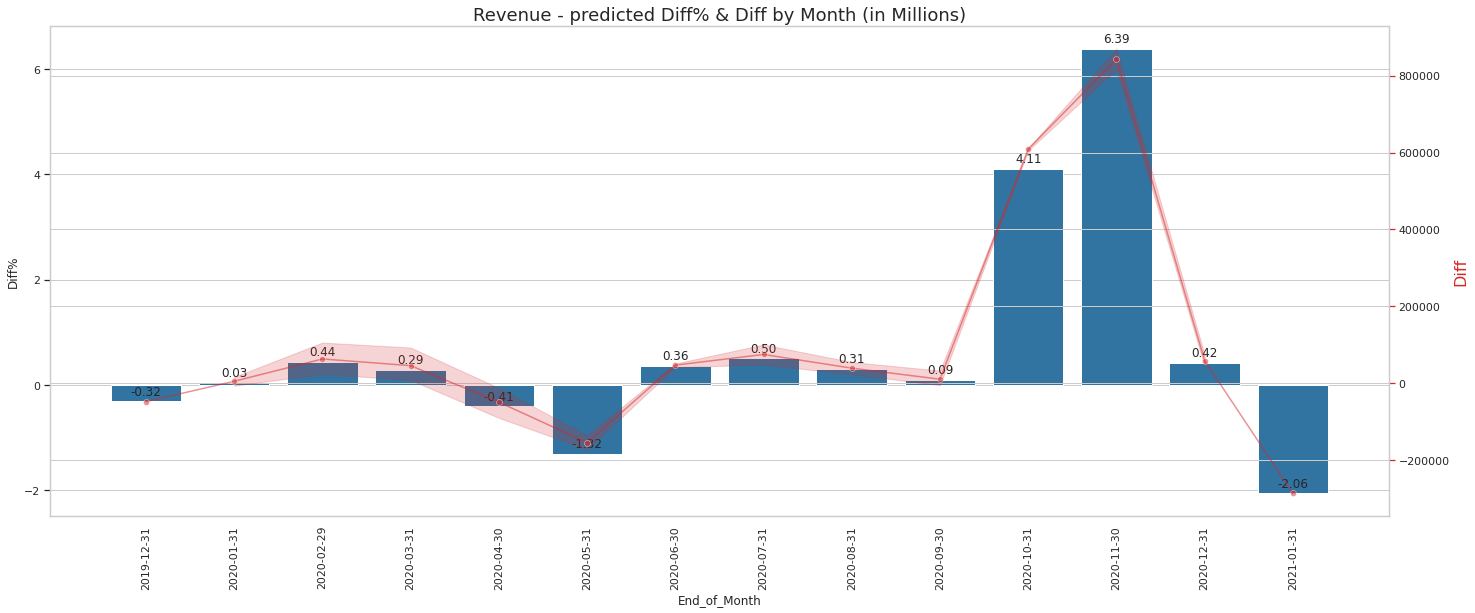

In [191]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

(fig, ax1) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset < 0').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.barplot(  # alpha=0.50,
    x='End_of_Month',
    y='Diff%',
    ci=None,
    data=final_merge_df1,
    color='tab:blue',
    ax=ax1,
    )
plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Revenue - predicted Diff% & Diff by Month (in Millions)', fontsize=18)
for p in g.patches:
    g.annotate(
        '{:,.2f}'.format(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        )
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax1.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='End_of_Month',
    y='Diff',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
plt.show()

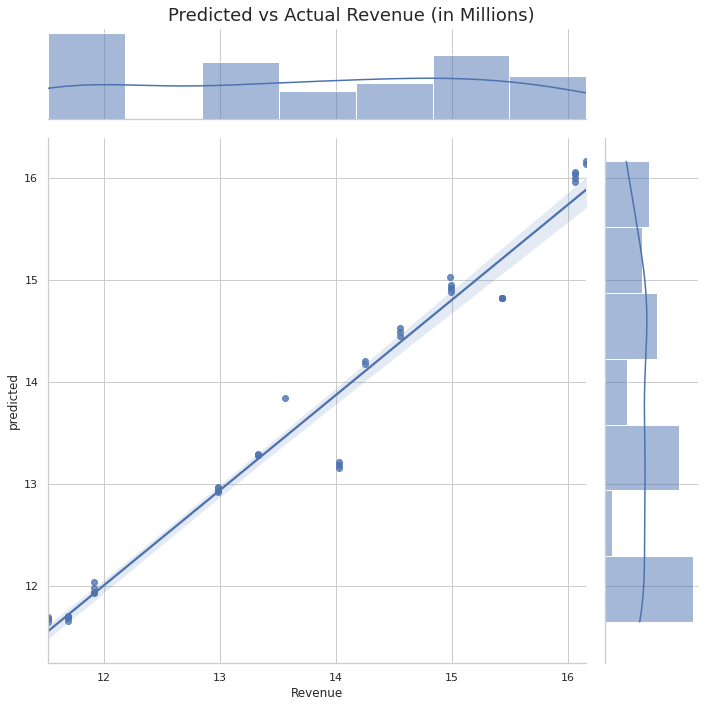

In [192]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset<0').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.jointplot(  
    data=final_merge_df1,
    x='Revenue',
    y='predicted',
    #hue='Snapshot_Date_Short',
    kind='reg',
    height=10
    )
#plt.xticks(rotation=90)
#plt.ylim(0,)
plt.suptitle('Predicted vs Actual Revenue (in Millions)', size=18)
plt.subplots_adjust( top = 0.95 ) 
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax1.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='End_of_Month',
    y='Diff',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

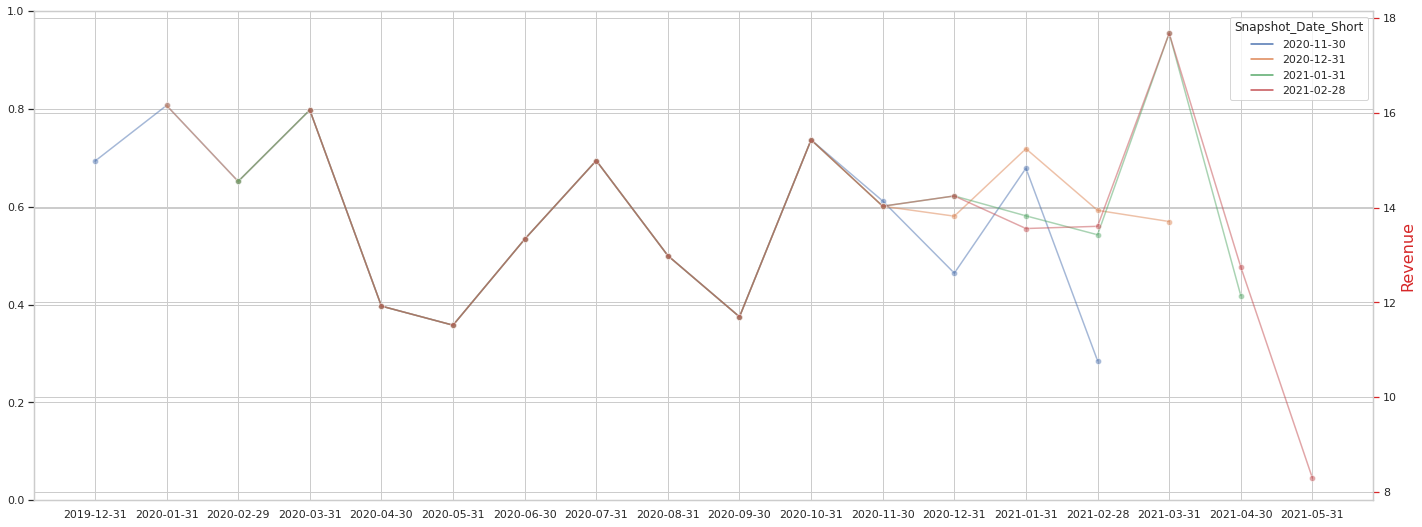

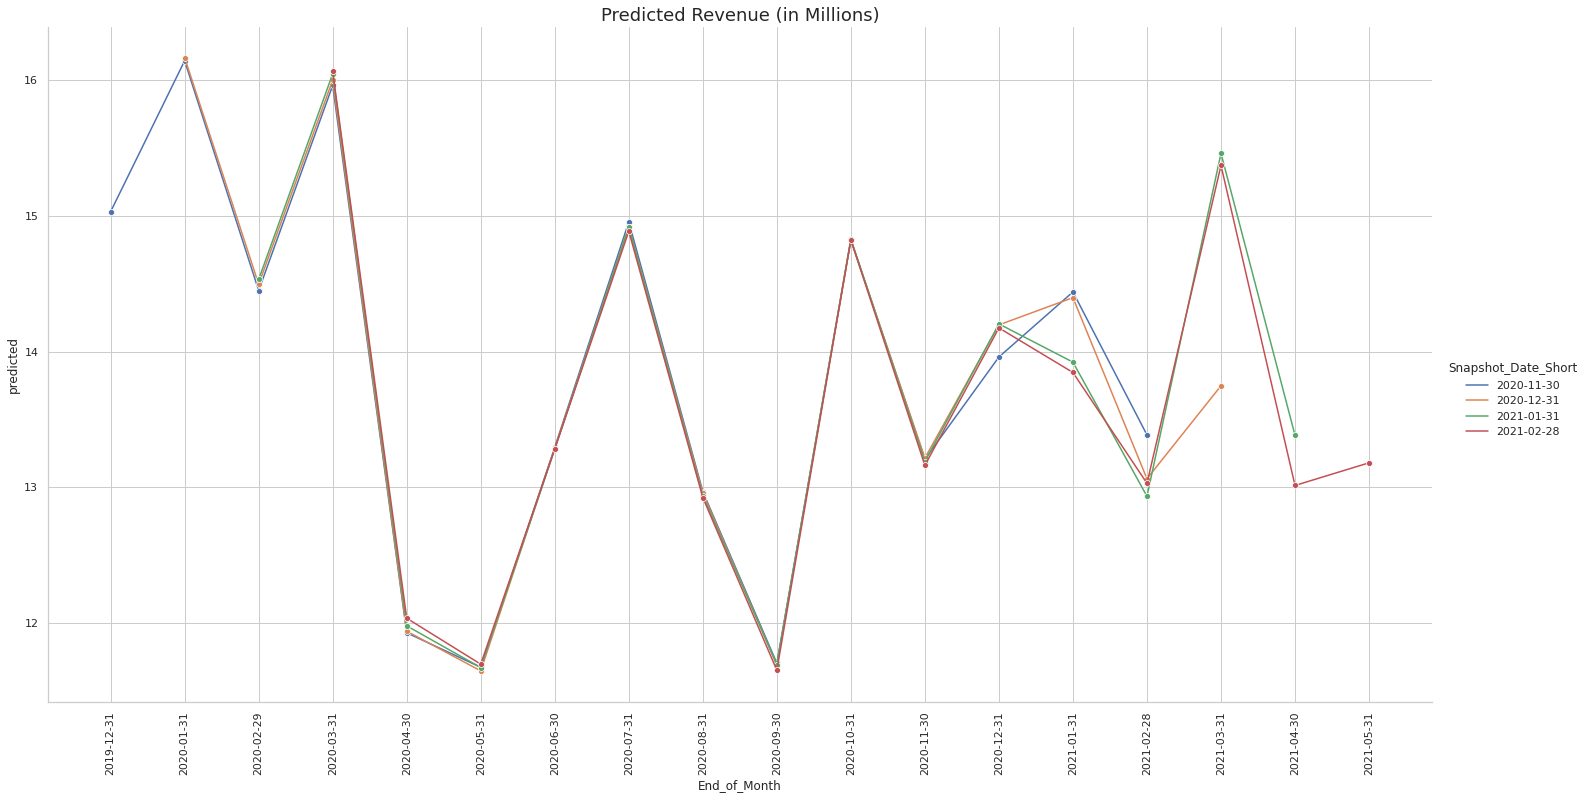

In [193]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

(fig, ax1) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.relplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='predicted',
    hue='Snapshot_Date_Short',
    kind='line',
    marker='o',
    height=10,
    aspect=2,
    ax=ax1
    )
plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Predicted Revenue (in Millions)', fontsize=18)
# '''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax1.twinx()
color='tab:red'
ax2.set_ylabel('Revenue', fontsize=16, color=color)
g = sns.lineplot(
    data=final_merge_df1,
    x='End_of_Month',
    y='Pipeline',
    hue='Snapshot_Date_Short',
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
# '''
plt.show()

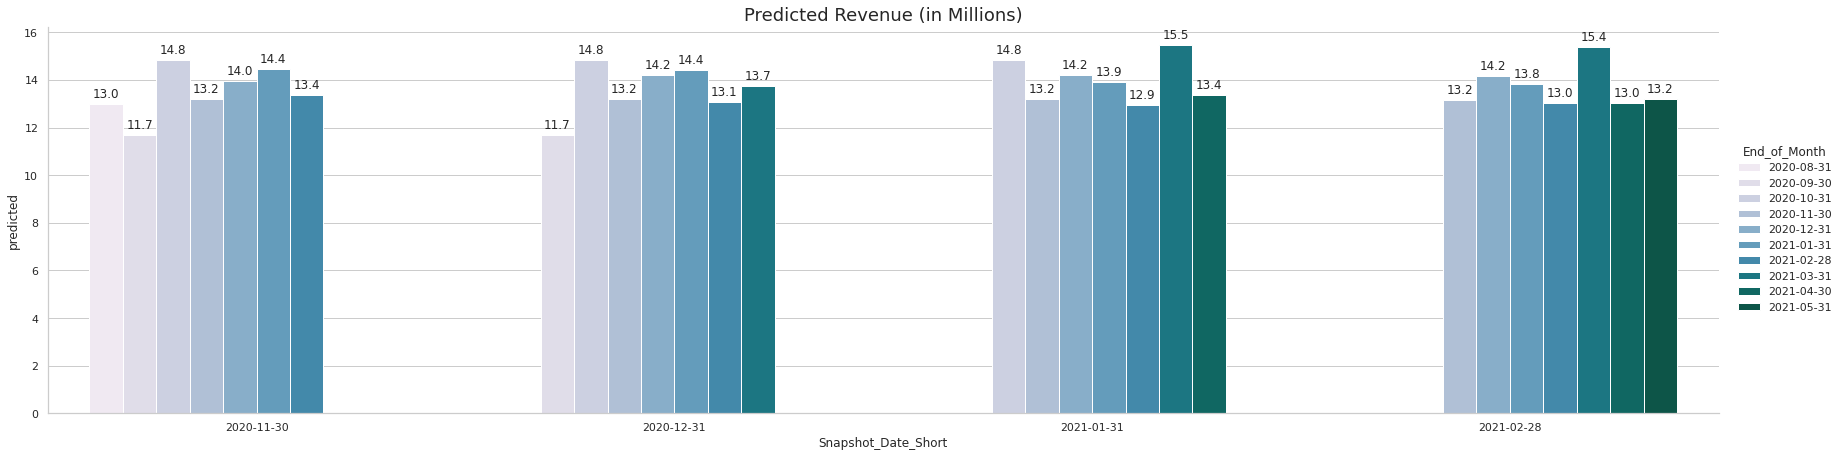

In [194]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='Snapshot_Date_Short',
    y='predicted',
    hue='End_of_Month',
    kind='bar',
    palette='PuBuGn',
    #alpha=.6,
    height=6,
    aspect=4,
    ax=ax
    )
#plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Predicted Revenue (in Millions)', fontsize=18)
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

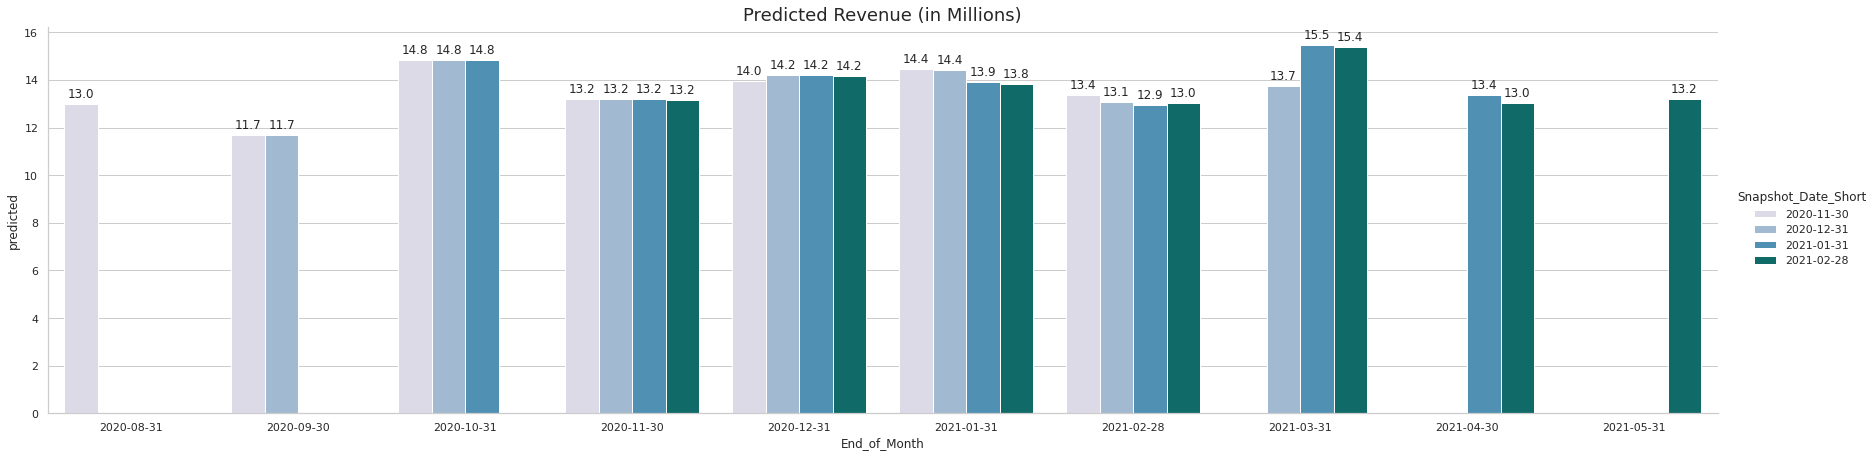

In [195]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='predicted',
    hue='Snapshot_Date_Short',
    kind='bar',
    palette='PuBuGn',
    #alpha=.6,
    height=6,
    aspect=4,
    ax=ax
    )
#plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Predicted Revenue (in Millions)', fontsize=18)
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

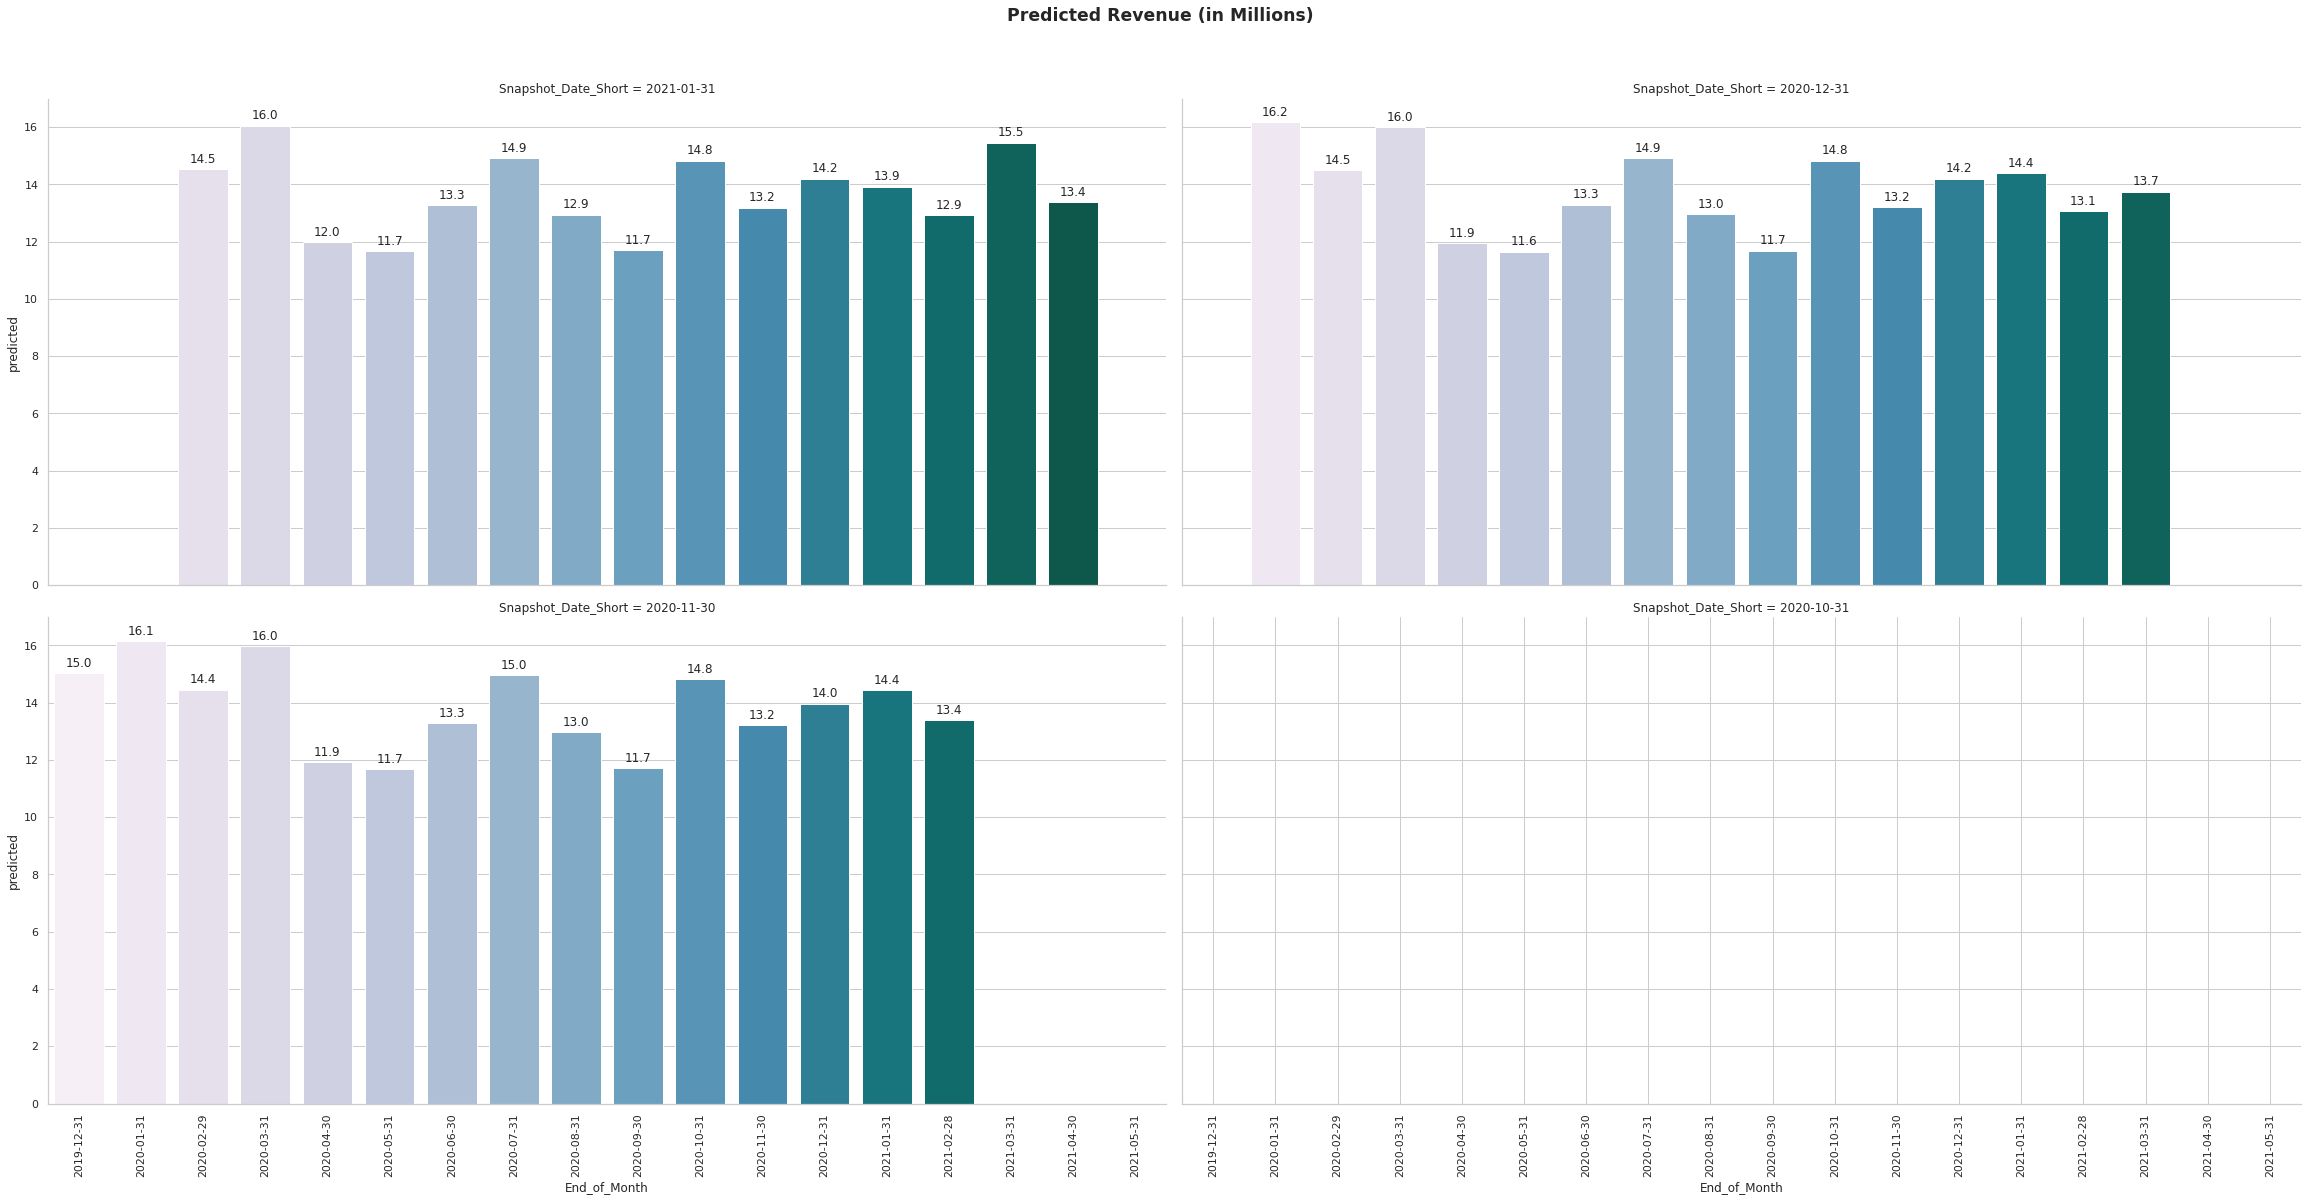

In [196]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='predicted',
    col='Snapshot_Date_Short',
    col_wrap=2,
    col_order=['2021-01-31','2020-12-31','2020-11-30','2020-10-31'],
    kind='bar',
    palette='PuBuGn',
    #alpha=.6,
    height=8,
    aspect=2,
    ax=ax
    )
#plt.ylim(0,)

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Revenue (in Millions) ', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

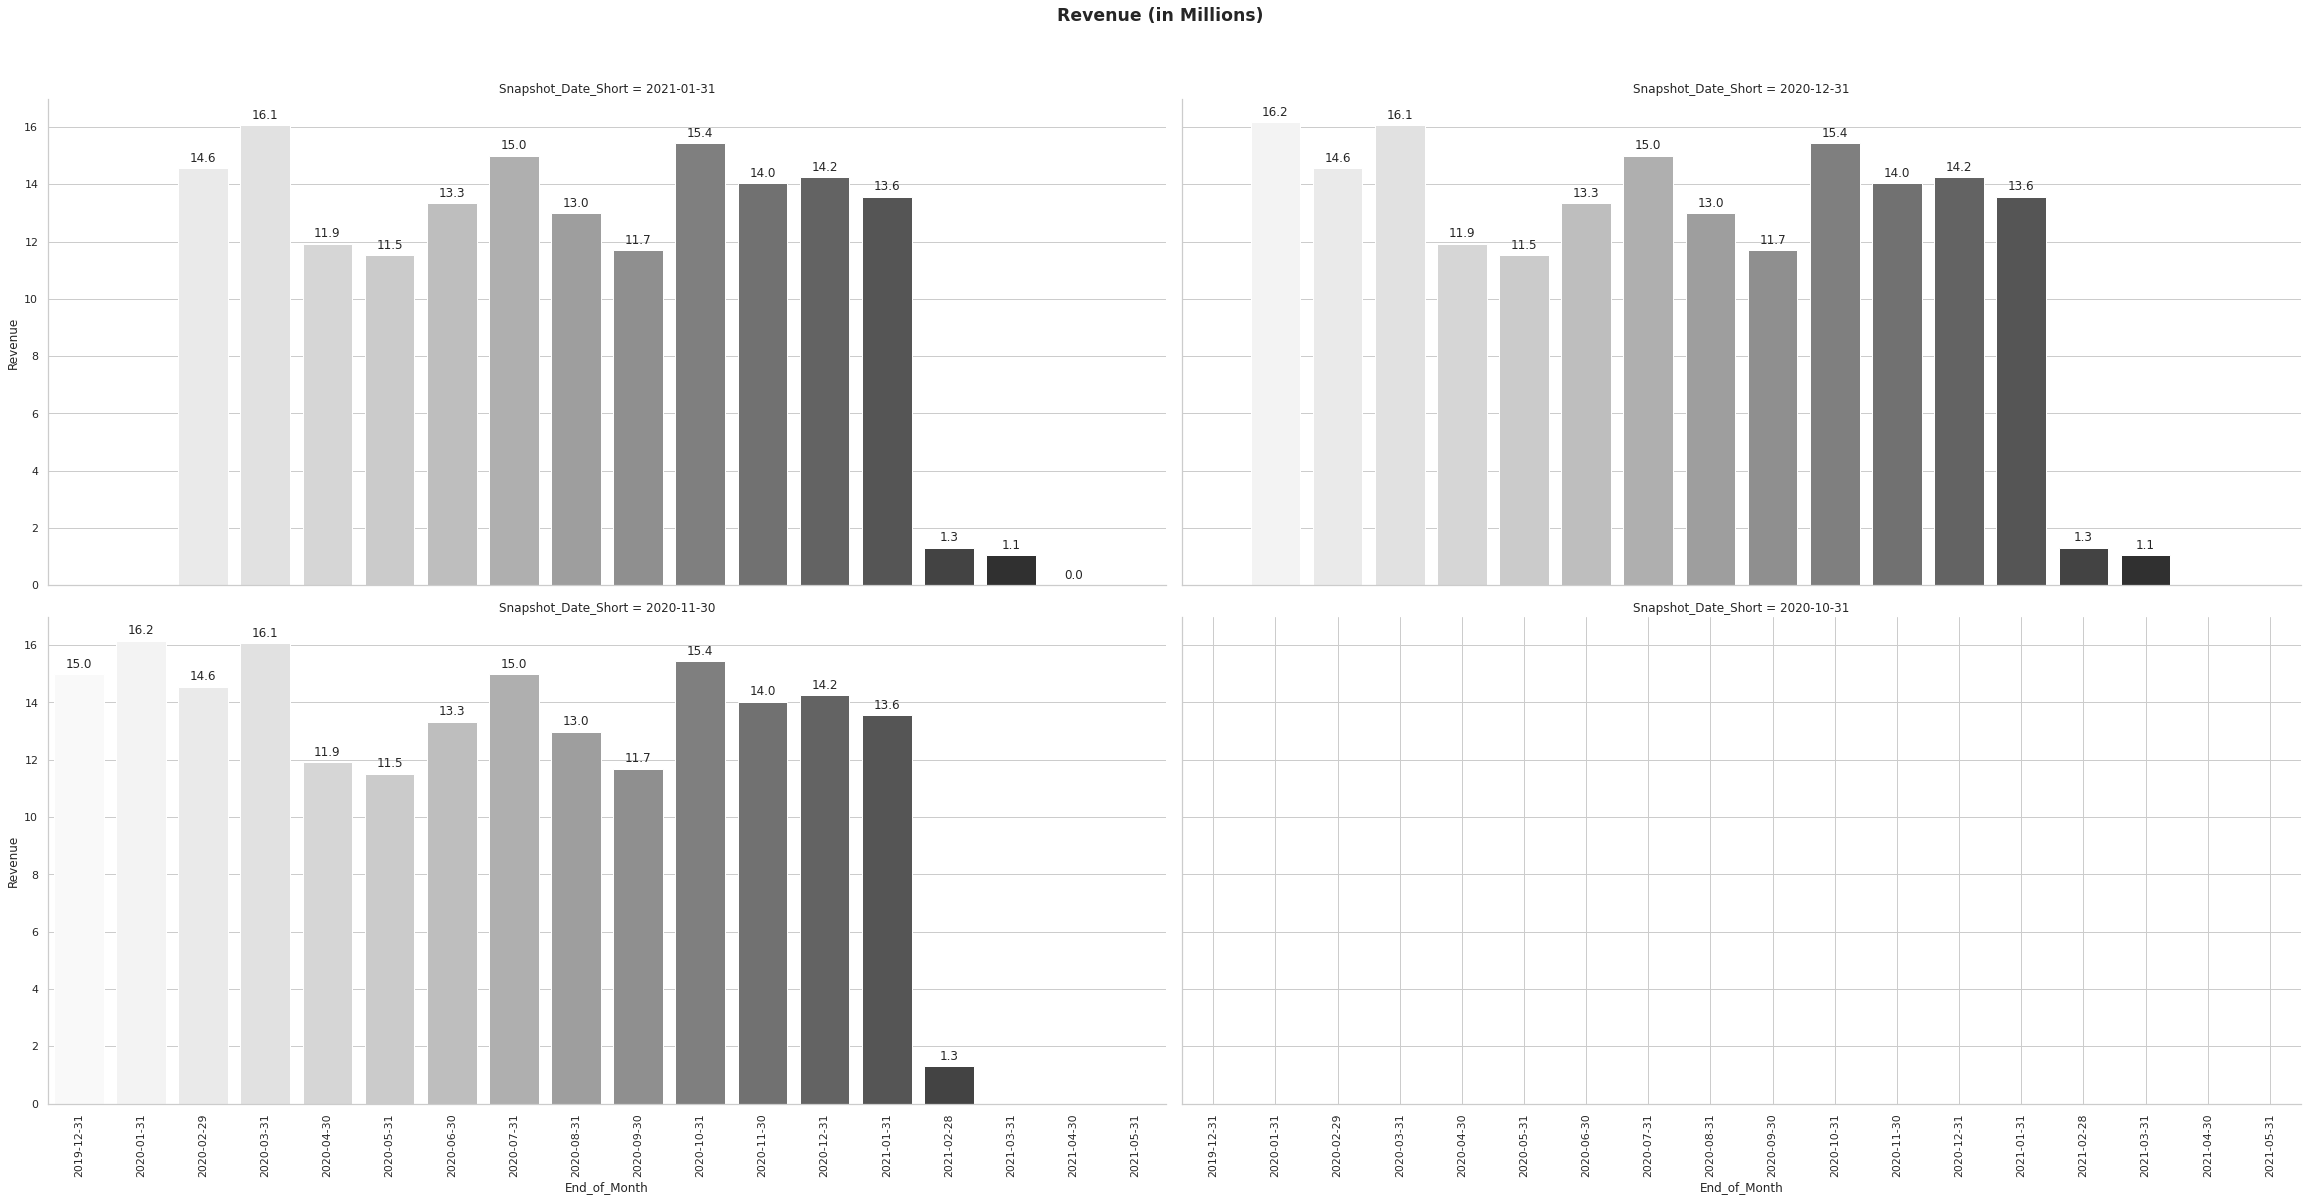

In [197]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='Revenue',
    col='Snapshot_Date_Short',
    col_wrap=2,
    col_order=['2021-01-31','2020-12-31','2020-11-30','2020-10-31'],
    kind='bar',
    palette='Greys',
    #alpha=.6,
    height=8,
    aspect=2,
    ax=ax
    )
#plt.ylim(0,)

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Revenue (in Millions) ', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

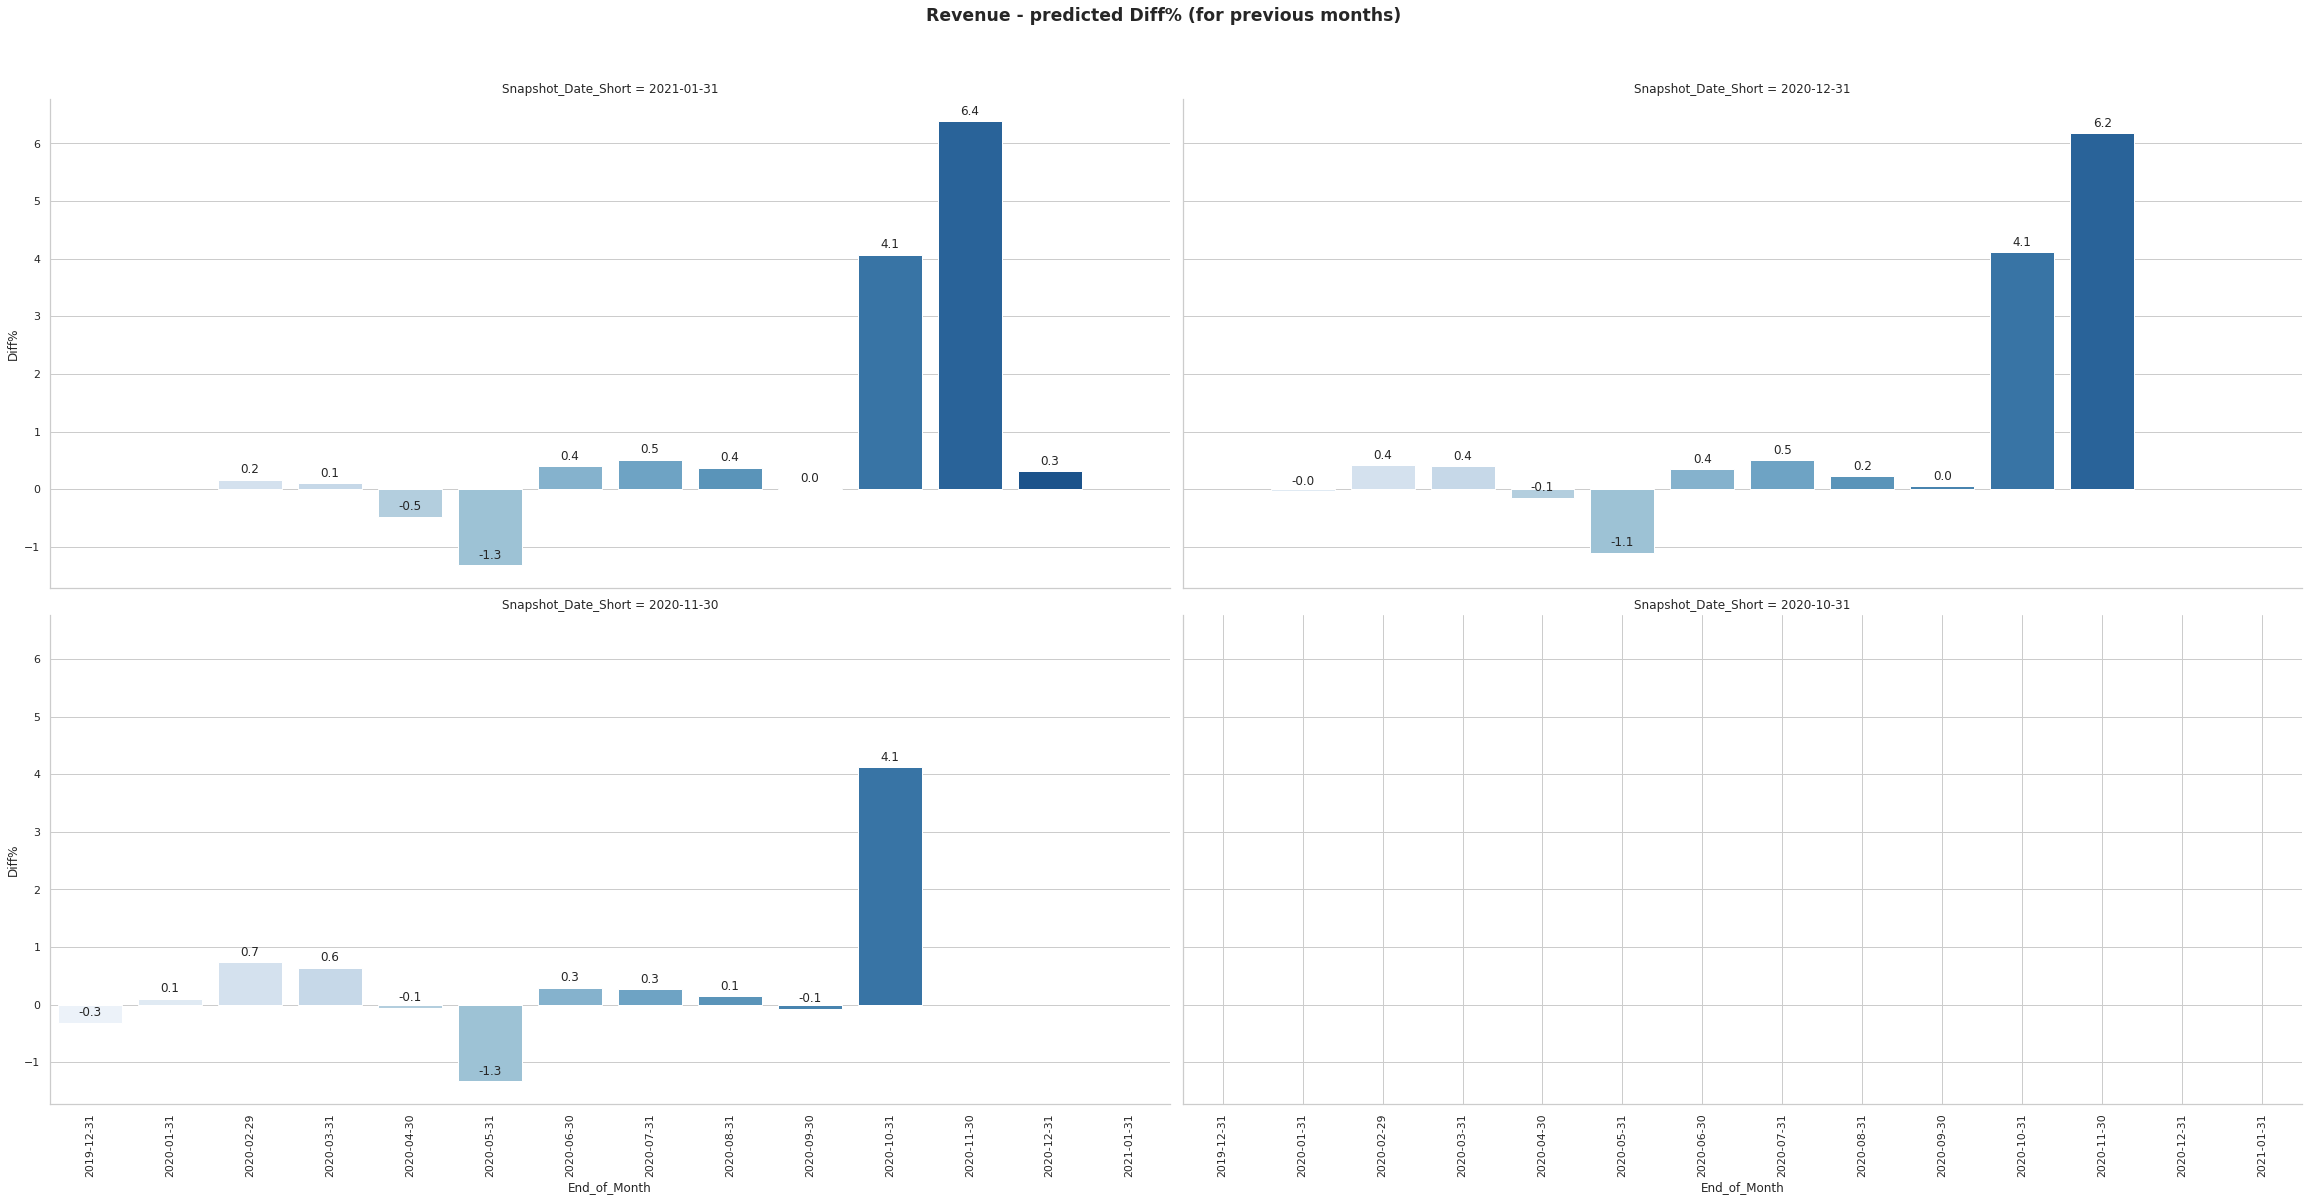

In [198]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset < 0').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='Diff%',
    col='Snapshot_Date_Short',
    col_wrap=2,
    col_order=['2021-01-31','2020-12-31','2020-11-30','2020-10-31'],
    kind='bar',
    palette='Blues',
    #alpha=.6,
    height=8,
    aspect=2,
    ax=ax
    )
#plt.ylim(0,)

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Revenue - predicted Diff% (for previous months)', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

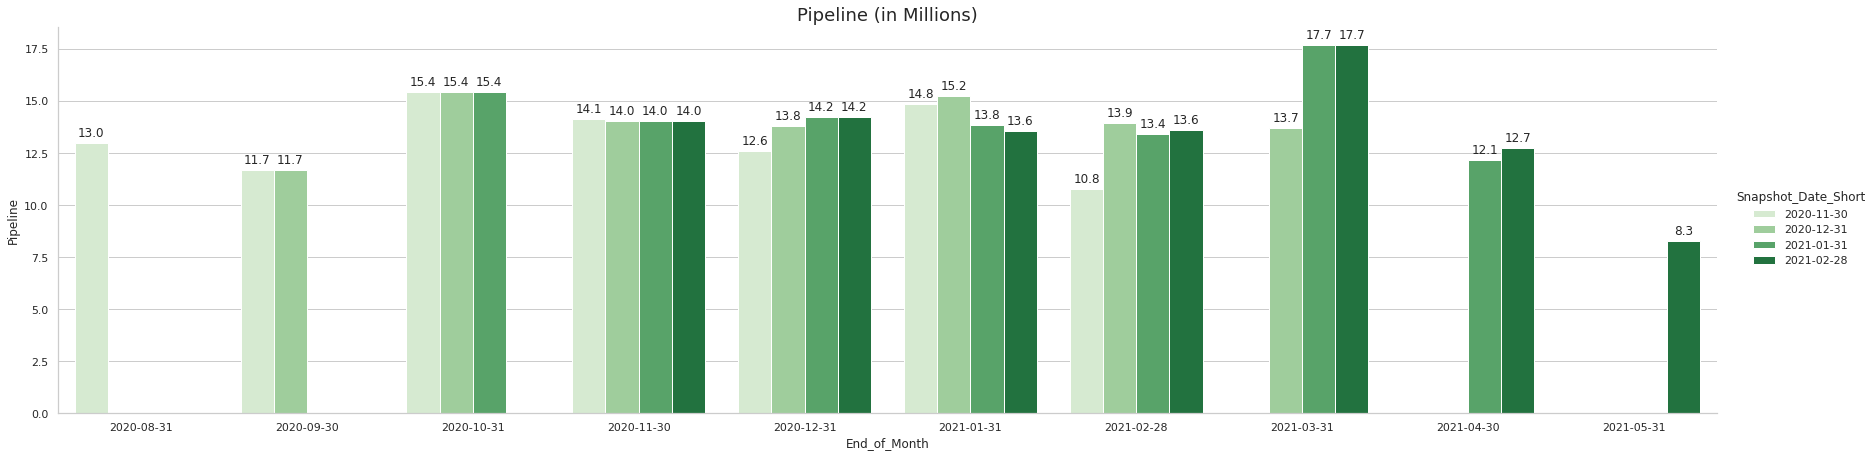

In [199]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='Pipeline',
    hue='Snapshot_Date_Short',
    kind='bar',
    palette='Greens',
    #alpha=.6,
    height=6,
    aspect=4,
    ax=ax
    )
#plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Pipeline (in Millions)', fontsize=18)
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

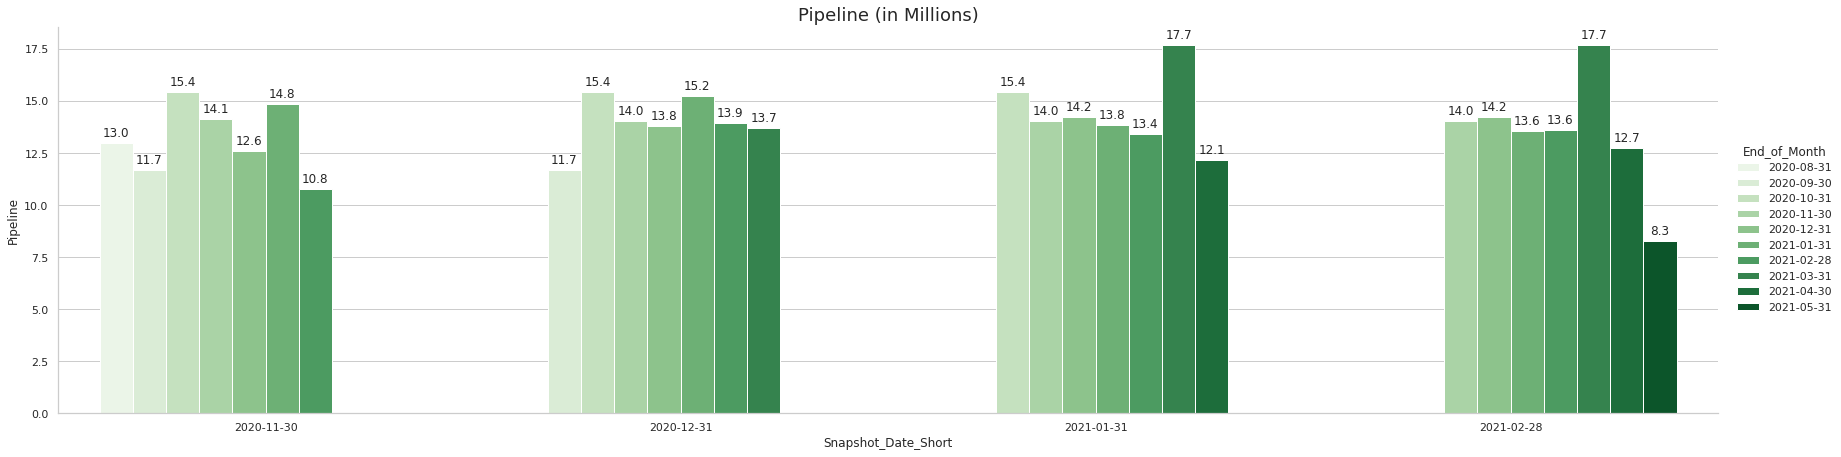

In [200]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='Snapshot_Date_Short',
    y='Pipeline',
    hue='End_of_Month',
    kind='bar',
    palette='Greens',
    #alpha=.6,
    height=6,
    aspect=4,
    ax=ax
    )
#plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Pipeline (in Millions)', fontsize=18)
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

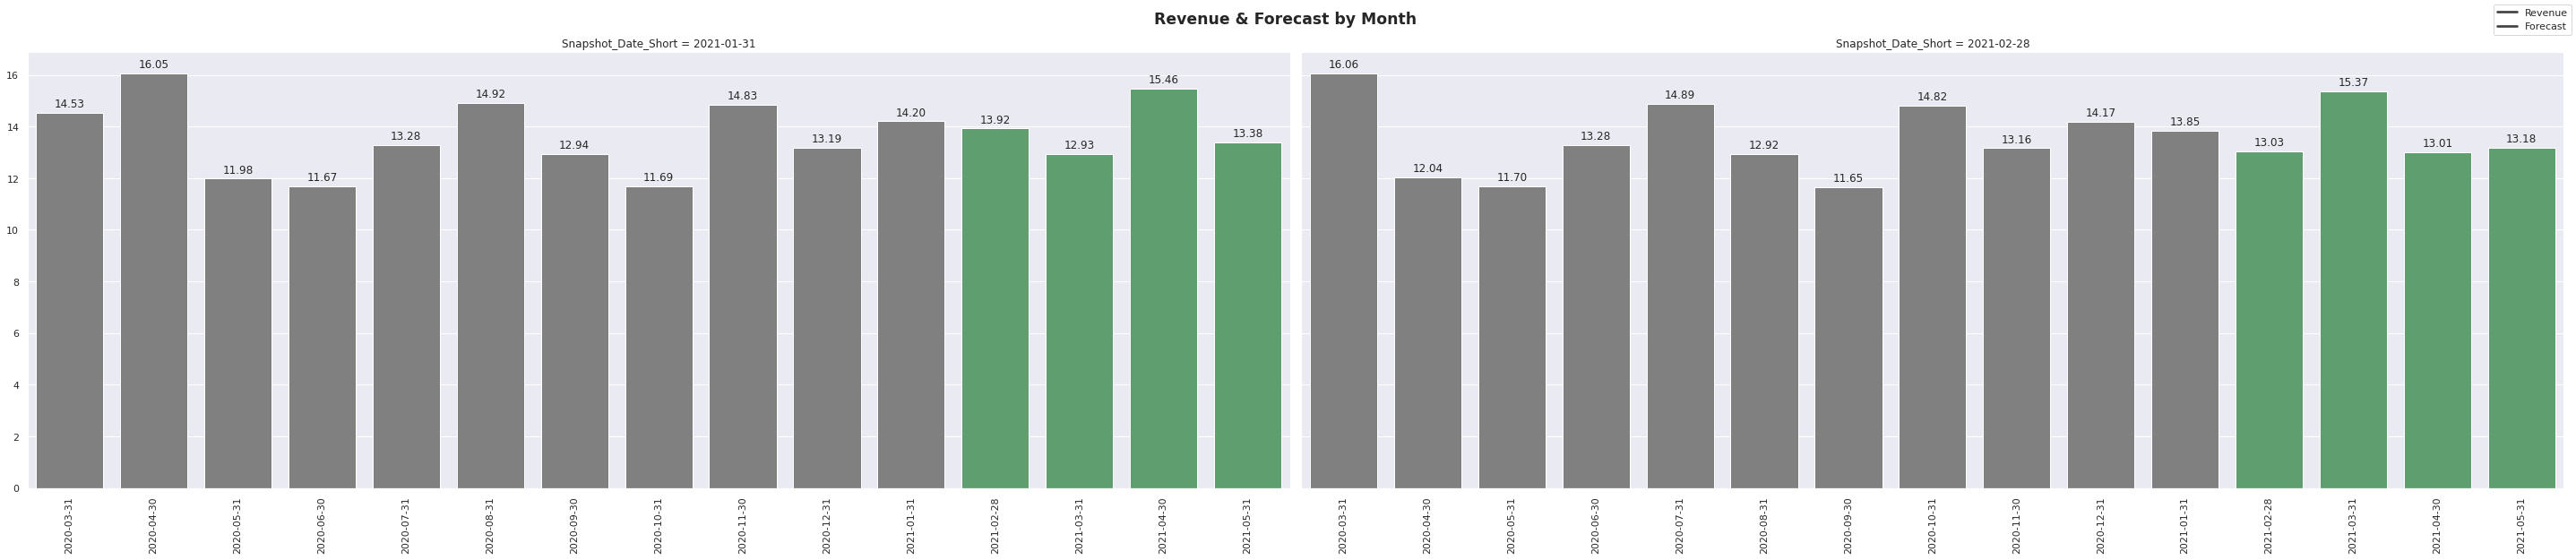

In [201]:
sns.set()
div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -1').copy()
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]
g = sns.FacetGrid(data=final_merge_df1, col='Snapshot_Date_Short',
                  height=8, aspect=2.5, col_wrap=2,
                  palette=clrs) #alpha=0.50

g.map_dataframe(sns.barplot, x='End_of_Month', y='Revenue_Forecast',
                palette=clrs)
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.2f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Revenue & Forecast by Month', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
g.fig.legend(['Revenue', 'Forecast'], facecolor='w')
plt.show()


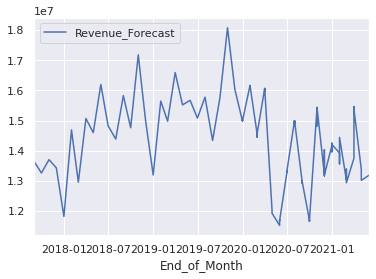

In [202]:
final_merge_df.plot(x='End_of_Month', y='Revenue_Forecast')

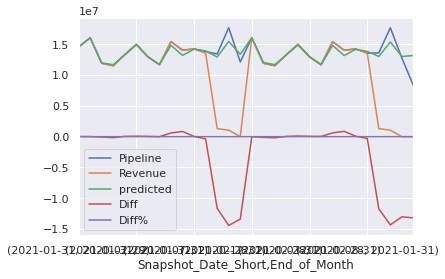

In [203]:
final_merge_pivot1.plot()

In [ ]:
# Bar plot for history and forecast revenues summary by month
sns.set()
#(fig, ax) = plt.subplots(figsize=(24, 9))

div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df2= final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df2['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df2['Snapshot_Date_Short']).dt.date.astype(str)
final_merge_df2['Revenue_Forecast'] = \
    round(final_merge_df2['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df2['Pipeline'] = \
    round(final_merge_df2['Pipeline'] / div_by_mil, 4)
final_merge_df2['predicted'] = \
    round(final_merge_df2['predicted'] / div_by_mil, 4)
values = final_merge_df2['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  # alpha=0.50,
    x='End_of_Month',
    y='predicted',
    data=final_merge_df2,
    hue='Relative_Offset',
    col='Snapshot_Date_Short',
    col_wrap=2,
    kind='bar',
    height=6,
    aspect=2,
    palette=clrs
    )

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}M'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g1 = sns.catplot(x='End_of_Month', y='Pipeline', 
    data=final_merge_df2,
    col='Snapshot_Date_Short',
    col_wrap=2,
    kind='bar',
    height=6,
    aspect=2,
    palette='Greens' )

g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Forecast by Snapshot Date, Month', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
#g.fig.legend(['Revenue', 'Forecast'], facecolor='w')
plt.show()

In [ ]:
# Bar plot for history and forecast revenues summary by month
sns.set()
#(fig, ax) = plt.subplots(figsize=(24, 9))

div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df2= final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df2['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df2['Snapshot_Date_Short']).dt.date.astype(str)
final_merge_df2['Revenue_Forecast'] = \
    round(final_merge_df2['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df2['Pipeline'] = \
    round(final_merge_df2['Pipeline'] / div_by_mil, 4)
final_merge_df2['predicted'] = \
    round(final_merge_df2['predicted'] / div_by_mil, 4)
values = final_merge_df2['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  # alpha=0.50,
    x='End_of_Month',
    y='predicted',
    data=final_merge_df2,
    #hue='Relative_Offset',
    col='Snapshot_Date_Short',
    col_wrap=2,
    kind='bar',
    height=6,
    aspect=2,
    palette=clrs
    )

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}M'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g1 = sns.catplot(x='End_of_Month', y='Pipeline', 
    data=final_merge_df2,
    col='Snapshot_Date_Short',
    col_wrap=2,
    kind='bar',
    height=6,
    aspect=2,
    palette='Greens' )

g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Forecast by Snapshot Date, Month', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
#g.fig.legend(['Revenue', 'Forecast'], facecolor='w')
plt.show()

In [ ]:
# Bar plot for history and forecast revenues summary by month
sns.set()
#(fig, ax) = plt.subplots(figsize=(24, 9))

div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df2= final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df2['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df2['Snapshot_Date_Short']).dt.date.astype(str)

final_merge_df2['Revenue_Forecast'] = \
    round(final_merge_df2['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df2['Revenue'] = \
    round(final_merge_df2['Revenue'] / div_by_mil, 4)
final_merge_df2['Pipeline'] = \
    round(final_merge_df2['Pipeline'] / div_by_mil, 4)
final_merge_df2['predicted'] = \
    round(final_merge_df2['predicted'] / div_by_mil, 4)

values = final_merge_df2['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  alpha=0.50,
    x='End_of_Month',
    y='predicted',
    data=final_merge_df2,
    #hue='Relative_Offset',
    col='Snapshot_Date_Short',
    col_wrap=2,
    kind='bar',
    height=6,
    aspect=2,
    palette='BrBG'
    )
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}M'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g.map_dataframe(sns.barplot, x='End_of_Month', y='Revenue', color = '.5',
                palette='Greys')
g.map_dataframe(sns.barplot, x='End_of_Month', y='Pipeline', color = '.5',
                palette='Greens')
g.add_legend()
g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Forecast by Snapshot Date, Month', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
#g.fig.legend()
plt.show()

In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
sns.set()
dfx = final_merge_pivot1.reset_index(inplace=False).copy()
g = sns.catplot(
    data=dfx,
    x='End_of_Month',
    y='predicted',
    hue='Snapshot_Date_Short',
    kind='bar',
    palette='BuGn',
    height=10,
    aspect=2
    )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Forecast by Snapshot Date, Month',
               fontsize='large', fontweight='bold')
g.fig.subplots_adjust(top=0.90)
g


In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
sns.set()
dfx = final_merge_pivot1.reset_index(inplace=False).copy()
g = sns.catplot(
    data=dfx,
    x='Snapshot_Date_Short',
    y='predicted',
    hue='End_of_Month',
    kind='bar',
    palette='BuGn',
    height=10,
    aspect=2
    )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Forecast by Snapshot Date, Month',
               fontsize='large', fontweight='bold')
g.fig.subplots_adjust(top=0.90)
g


In [ ]:
STOP*************************************************************

In [ ]:
Operationalize
#Operationalization means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.
description = 'AutoML Revenue forecaster'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id)

In [ ]:
#Develop the scoring script
#For the deployment we need a function which will run the forecast on serialized data. It can be obtained from the best_run.
script_file_name = 'score_fcast.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)

In [ ]:
#Deploy the model as a Web Service on Azure Container 
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(environment = best_run.get_environment(), 
                                   entry_script = script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 2, 
                                               tags = {'type': 'automl-forecasting'},
                                               description = 'Automl forecasting revenue service')

aci_service_name = 'automl-revenue-forecast-01'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

In [ ]:
aci_service.get_logs()

In [ ]:
#Call the service
import json
X_query = X_test.copy()
# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)
# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
test_sample = json.dumps({'data': X_query.to_dict(orient='records')})
response = aci_service.run(input_data = test_sample)
# translate from networkese to datascientese
try: 
    res_dict = json.loads(response)
    y_fcst_all = pd.DataFrame(res_dict['index'])
    y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')
    y_fcst_all['forecast'] = res_dict['forecast']    
except:
    print(res_dict)

In [ ]:
y_fcst_all.head()

In [ ]:
#Delete the web service if desired
#serv = Webservice(ws, 'automl-revenue-forecast-01')
#serv.delete()     # don't do it accidentally

In [ ]:
STOP

In [ ]:
#Export revenue only for time series forecast
#cols = revhist1.columns
#revtime_hist = merge_df[cols].query('End_of_Month < @current_eom').reset_index(drop=True)
#revtime_hist = merge_final.query('End_of_Month < @current_eom').reset_index(drop=True)
#revtime_hist.to_csv('revtime_hist.csv', index=False)
#revtime_foreast = merge_final.query('End_of_Month >= @current_eom').reset_index(drop=True)
#revtime_foreast.drop(columns=['Revenue'], axis=1, inplace = True)
#revtime_foreast.to_csv('revtime_foreast.csv', index=False)

In [ ]:
#Plot dataset
sns.set()
sns.set_context('talk') #In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style='whitegrid') #Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks. 
# Save a palette to a variable:
palette = sns.color_palette('Accent',8)
# Use palplot and pass in the variable:
sns.palplot(palette)
# Set the palette using the name of a palette:
sns.set_palette(palette)

dataset = revtime_hist
dataset['End_of_Month'] = pd.to_datetime(dataset['End_of_Month'])
dataset = dataset.set_index('End_of_Month')
values = dataset.values
# specify columns to plot
groups = [0,1] #, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.1, loc='right')
    i += 1
plt.show()

In [ ]:
dataset['Revenue'].plot()